[[이유한님] 캐글 코리아 캐글 스터디 커널 커리큘럼](https://kaggle-kr.tistory.com/32)

[2nd level. Porto Seguro’s Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction)  
'#'은 wonder1ng 각주  
표기가 없거나 '##~'은 원본 각주(혹은 코드)

[Data Preparation & Exploration](https://www.kaggle.com/code/bertcarremans/data-preparation-exploration/notebook)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
# from sklearn.preprocessing import Imputer 변경된 듯
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

# pd.set_option('display.max_columns', 100)

## Data at first sight
Here is an excerpt of the the data description for the competition:  
  
- Features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc).
- Feature names include the postfix bin to indicate binary features and cat to indicate categorical features.
- Features without these designations are either continuous or ordinal.
- Values of -1 indicate that the feature was missing from the observation.
- The target columns signifies whether or not a claim was filed for that policy holder.
   
Ok, that's important information to get us started. Let's have a quick look at the first and last rows to confirm all of this.  
  
#### DeeL 번역
다음은 대회에 대한 데이터 설명의 발췌문입니다:  
  
- 유사한 그룹에 속하는 피처는 피처 이름에 해당 그룹으로 태그가 지정됩니다(예: ind, reg, car, calc).
- 특징 이름에는 이진 특징을 나타내는 최종 추가 bin과 범주형 특징을 나타내는 cat이 포함됩니다.
- 이러한 지정이 없는 특징은 연속형 또는 서수형입니다.
- 값이 -1이면 해당 특징이 관찰에서 누락되었음을 나타냅니다.
- 대상 열은 해당 보험 계약자에 대한 보험금 청구가 접수되었는지 여부를 나타냅니다.
   
자, 이제 시작하기 위한 중요한 정보입니다. 이 모든 것을 확인하기 위해 첫 번째 행과 마지막 행을 간단히 살펴보겠습니다.

In [2]:
train = pd.read_csv('./input/porto-seguro-safe-driver-prediction/train.csv')
test = pd.read_csv('./input/porto-seguro-safe-driver-prediction/test.csv')
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [3]:
train.tail()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
595207,1488013,0,3,1,10,0,0,0,0,0,...,4,1,9,6,0,1,1,0,1,1
595208,1488016,0,5,1,3,0,0,0,0,0,...,4,1,3,8,1,0,1,0,1,1
595209,1488017,0,1,1,10,0,0,1,0,0,...,3,2,2,6,0,0,1,0,0,0
595210,1488021,0,5,2,3,1,0,0,0,1,...,4,1,4,2,0,1,1,1,0,0
595211,1488027,0,0,1,8,0,0,1,0,0,...,4,4,3,8,0,1,0,0,0,0


We indeed see the following  
  
- binary variables  
- categorical variables of which the category values are integers  
- other variables with integer or float values  
- variables with -1 representing missing values  
- the target variable and an ID variable  

In [4]:
print(train.shape)
train.drop_duplicates() # 중복 값 제거
print(train.shape)
train.info()

(595212, 59)
(595212, 59)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-nul

In [5]:
print(test.shape)
train.drop_duplicates() # 중복 값 제거
print(test.shape)
test.info()

(892816, 58)
(892816, 58)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892816 entries, 0 to 892815
Data columns (total 58 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              892816 non-null  int64  
 1   ps_ind_01       892816 non-null  int64  
 2   ps_ind_02_cat   892816 non-null  int64  
 3   ps_ind_03       892816 non-null  int64  
 4   ps_ind_04_cat   892816 non-null  int64  
 5   ps_ind_05_cat   892816 non-null  int64  
 6   ps_ind_06_bin   892816 non-null  int64  
 7   ps_ind_07_bin   892816 non-null  int64  
 8   ps_ind_08_bin   892816 non-null  int64  
 9   ps_ind_09_bin   892816 non-null  int64  
 10  ps_ind_10_bin   892816 non-null  int64  
 11  ps_ind_11_bin   892816 non-null  int64  
 12  ps_ind_12_bin   892816 non-null  int64  
 13  ps_ind_13_bin   892816 non-null  int64  
 14  ps_ind_14       892816 non-null  int64  
 15  ps_ind_15       892816 non-null  int64  
 16  ps_ind_16_bin   892816 non-nul

We are missing one variable in the test set, but this is the target variable. So that's fine.  
Let's now invesigate how many variables of each type we have.  
  
So later on we can create dummy variables for the 14 categorical variables. The bin variables are already binary and do not need dummification.

## Metadata
To facilitate the data management, we'll store meta-information about the variables in a DataFrame. This will be helpful when we want to select specific variables for analysis, visualization, modeling, ...  
  
Concretely we will store:  
- role: input, ID, target
- level: nominal, interval, ordinal, binary
- keep: True or False
- dtype: int, float, str

In [6]:
data = []
for f in train.columns:
    # Defining the role
    if f=='target': 
        role = 'target'
    elif f=='id':
        role = 'id'
    else:
        role = 'input'

    # Defining the level
    if 'bin' in f or f == 'target':
        level = 'binary'
    elif 'cat' in f or f == 'id':
        level = 'nominal'
    elif train[f].dtype=='float64':
        level = 'interval'
    elif train[f].dtype=='int64':
        level = 'ordinal'

    # Initialize keep to True for all variables except for id
    keep = False if f=='id' else True

    # Defining the data type
    dtype = train[f].dtype

    # Creating a Dict that contains all the metadata for the variable
    f_dict = {
        'varname': f,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }
    data.append(f_dict)

meta = pd.DataFrame(data=data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
# meta = pd.DataFrame(data=data, columns=list(f_dict.keys()))
meta.set_index('varname', inplace=True)
meta

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


In [7]:
meta[(meta.level=='nominal')&(meta.keep)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

In [8]:
pd.DataFrame({'count': meta.groupby(['role', 'level'])['role'].size()}).reset_index()

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


## Descriptive statistics
We can also apply the describe method on the dataframe. However, it doesn't make much sense to calculate the mean, std, ... on categorical variables and the id variable. We'll explore the categorical variables visually later.  
  
Thanks to our meta file we can easily select the variables on which we want to compute the descriptive statistics. To keep things clear, we'll do this per data type.  

#### DeepL 번역
데이터 프레임에 설명 방법을 적용할 수도 있습니다. 그러나 범주형 변수와 ID 변수에 대해 평균, 표준편차, ...를 계산하는 것은 그다지 의미가 없습니다. 범주형 변수는 나중에 시각적으로 살펴보겠습니다.  
  
메타 파일 덕분에 설명적 통계를 계산할 변수를 쉽게 선택할 수 있습니다. 명확하게 하기 위해 데이터 유형별로 이 작업을 수행하겠습니다.

In [9]:
v = meta[(meta.level == 'interval') & (meta.keep)].index
train[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


__reg variables__  
- only ps_reg_03 has missing values
- the range (min to max) differs between the variables. We could apply scaling (e.g. StandardScaler), but it depends on the classifier we will want to use.  
  
__car variables__  
- ps_car_12 and ps_car_15 have missing values
- again, the range differs and we could apply scaling.
  
__calc variables__  
- no missing values
- this seems to be some kind of ratio as the maximum is 0.9
- all three _calc variables have very similar distributions  
  
Overall, we can see that the range of the interval variables is rather small. Perhaps some transformation (e.g. log) is already applied in order to anonymize the data?

In [10]:
## Ordinal variables
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
train[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


In [11]:
## Binary variables
v = meta[(meta.level == 'binary') & (meta.keep)].index
train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Handling imbalanced classes
As we mentioned above the proportion of records with target=1 is far less than target=0. This can lead to a model that has great accuracy but does have any added value in practice. Two possible strategies to deal with this problem are:  
- oversampling records with target=1
- undersampling records with target=0  
  
There are many more strategies of course and MachineLearningMastery.com gives a nice overview. As we have a rather large training set, we can go for undersampling.

In [12]:
desired_aprioir = 0.10

## Get the indices per target value
idx_0 = train[train.target==0].index
idx_1 = train[train.target==1].index

## Get original number of records per target value
nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])

## Calculates the undersampling rate and resulting number of records with target=0
undersampling_rate = ((1-desired_aprioir)*nb_1)/(nb_0*desired_aprioir)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0:', undersampling_rate)
print('Number of records with target=0 after undersampling:', undersampled_nb_0)

# print(train.shape, nb_0, nb_1)
# print((1-desired_aprioir)*nb_1, '/', nb_0*desired_aprioir, ((1-desired_aprioir)*nb_1)/(nb_0*desired_aprioir))

## Randomly select records with target=0 to get at the desired a priori
undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

## Construct list with remaing indices
idx_list = list(undersampled_idx) + list(idx_1)

## Return undersample data frame
train = train.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undersampling: 195246


## Data Quality Checks

In [13]:
## Checking missing values

vars_with_missing = []
# for f in train.columns.sort_values():
for f in train.columns:
    missings = train[train[f]==-1][f].count()
    if missings>0:
        vars_with_missing.append(f)
        missings_perc = missings/train.shape[0]

        print(f'Variable {f:<13} has {missings:>6} record ({missings_perc:>6.2%}) with missing values')

print(f'In total, there are {len(vars_with_missing)} variables with missing values')

Variable ps_ind_02_cat has    103 record ( 0.05%) with missing values
Variable ps_ind_04_cat has     51 record ( 0.02%) with missing values
Variable ps_ind_05_cat has   2256 record ( 1.04%) with missing values
Variable ps_reg_03     has  38580 record (17.78%) with missing values
Variable ps_car_01_cat has     62 record ( 0.03%) with missing values
Variable ps_car_02_cat has      2 record ( 0.00%) with missing values
Variable ps_car_03_cat has 148367 record (68.39%) with missing values
Variable ps_car_05_cat has  96026 record (44.26%) with missing values
Variable ps_car_07_cat has   4431 record ( 2.04%) with missing values
Variable ps_car_09_cat has    230 record ( 0.11%) with missing values
Variable ps_car_11     has      1 record ( 0.00%) with missing values
Variable ps_car_14     has  15726 record ( 7.25%) with missing values
In total, there are 12 variables with missing values


- __ps_car_03_cat and ps_car_05_cat__ have a large proportion of records with missing values. Remove these variables.
- For the other categorical variables with missing values, we can leave the missing value -1 as such.
- __ps_reg_03__ (continuous) has missing values for 18% of all records. Replace by the mean.
- __ps_car_11__ (ordinal) has only 5 records with misisng values. Replace by the mode.
- __ps_car_12__ (continuous) has only 1 records with missing value. Replace by the mean.
- __ps_car_14__ (continuous) has missing values for 7% of all records. Replace by the mean.

In [14]:
## Dropping the variables with too many missing values
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
train.drop(vars_to_drop, inplace=True, axis=1)
meta.loc[(vars_to_drop), 'keep'] = False    ## Updating the meta

## Imputing with the mean or mode
mean_imp = SimpleImputer(missing_values=-1, strategy='mean')
mode_imp = SimpleImputer(missing_values=-1, strategy='most_frequent')
train['ps_reg_03'] = mean_imp.fit_transform(train[['ps_reg_03']])
train['ps_car_12'] = mean_imp.fit_transform(train[['ps_car_12']])
train['ps_car_14'] = mean_imp.fit_transform(train[['ps_car_14']])
train['ps_car_11'] = mode_imp.fit_transform(train[['ps_car_11']])
train[['ps_reg_03', 'ps_car_12', 'ps_car_14', 'ps_car_11']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216940 entries, 0 to 216939
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   ps_reg_03  216940 non-null  float64
 1   ps_car_12  216940 non-null  float64
 2   ps_car_14  216940 non-null  float64
 3   ps_car_11  216940 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 6.6 MB


### Checking the cardinality of the categorical variables
Cardinality refers to the number of different values in a variable. As we will create dummy variables from the categorical variables later on, we need to check whether there are variables with many distinct values. We should handle these variables differently as they would result in many dummy variables.

In [15]:
v = meta[(meta.level=='nominal')&(meta.keep)].index
print(v)

for f in v:
    dist_values = train[f].value_counts().shape[0]
    # dist_values = train[f].nunique()
    print(f'Variable {f} has {dist_values} distinct values')

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_04_cat', 'ps_car_06_cat', 'ps_car_07_cat',
       'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')
Variable ps_ind_02_cat has 5 distinct values
Variable ps_ind_04_cat has 3 distinct values
Variable ps_ind_05_cat has 8 distinct values
Variable ps_car_01_cat has 13 distinct values
Variable ps_car_02_cat has 3 distinct values
Variable ps_car_04_cat has 10 distinct values
Variable ps_car_06_cat has 18 distinct values
Variable ps_car_07_cat has 3 distinct values
Variable ps_car_08_cat has 2 distinct values
Variable ps_car_09_cat has 6 distinct values
Variable ps_car_10_cat has 3 distinct values
Variable ps_car_11_cat has 104 distinct values


In [16]:
## Script by https://www.kaggle.com/ogrellier
## Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features

def add_noise(series:pd.Series, noise_level:int) -> pd.Series:
    return series*(1+noise_level*np.random.randn(len(series)))

def traget_encode(trn_series=None,
                  tst_series=None,
                  target=None,
                  min_samples_leaf=1,
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    ## Compute target mean
    averages = temp.groupby(trn_series.name)[target.name].agg(['mean', 'count'])
    ## Compute smoothing
    smoothing = 1/(1+np.exp(-(averages['count']-min_samples_leaf)/smoothing))
    ## Apply average function to all target data
    prior = target.mean()
    ## The bigger the count the less full_avg is taken into account
    averages[target.name] = prior*(1-smoothing)+averages['mean']*smoothing
    averages.drop(['mean','count'], axis=1, inplace=True)
    ## Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name+'_mean').fillna(prior)
    ## pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name+'mean').fillna(prior)
    ## pd.merge dose not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [17]:
train_encoded, test_encoded = traget_encode(train['ps_car_11_cat'],
                                            test['ps_car_11_cat'],
                                            target=train.target,
                                            min_samples_leaf=100,
                                            smoothing=10,
                                            noise_level=0.01)

train['ps_car_11_cat_te'] = train_encoded
train.drop('ps_car_11_cat', axis=1, inplace=True)
meta.loc['ps_car_11_cat', 'keep'] = False   ## Updating the meta
test['ps_car_11_cat_te'] = test_encoded
test.drop('ps_car_11_cat', axis=1, inplace=True)

## Exploratory Data Visualization

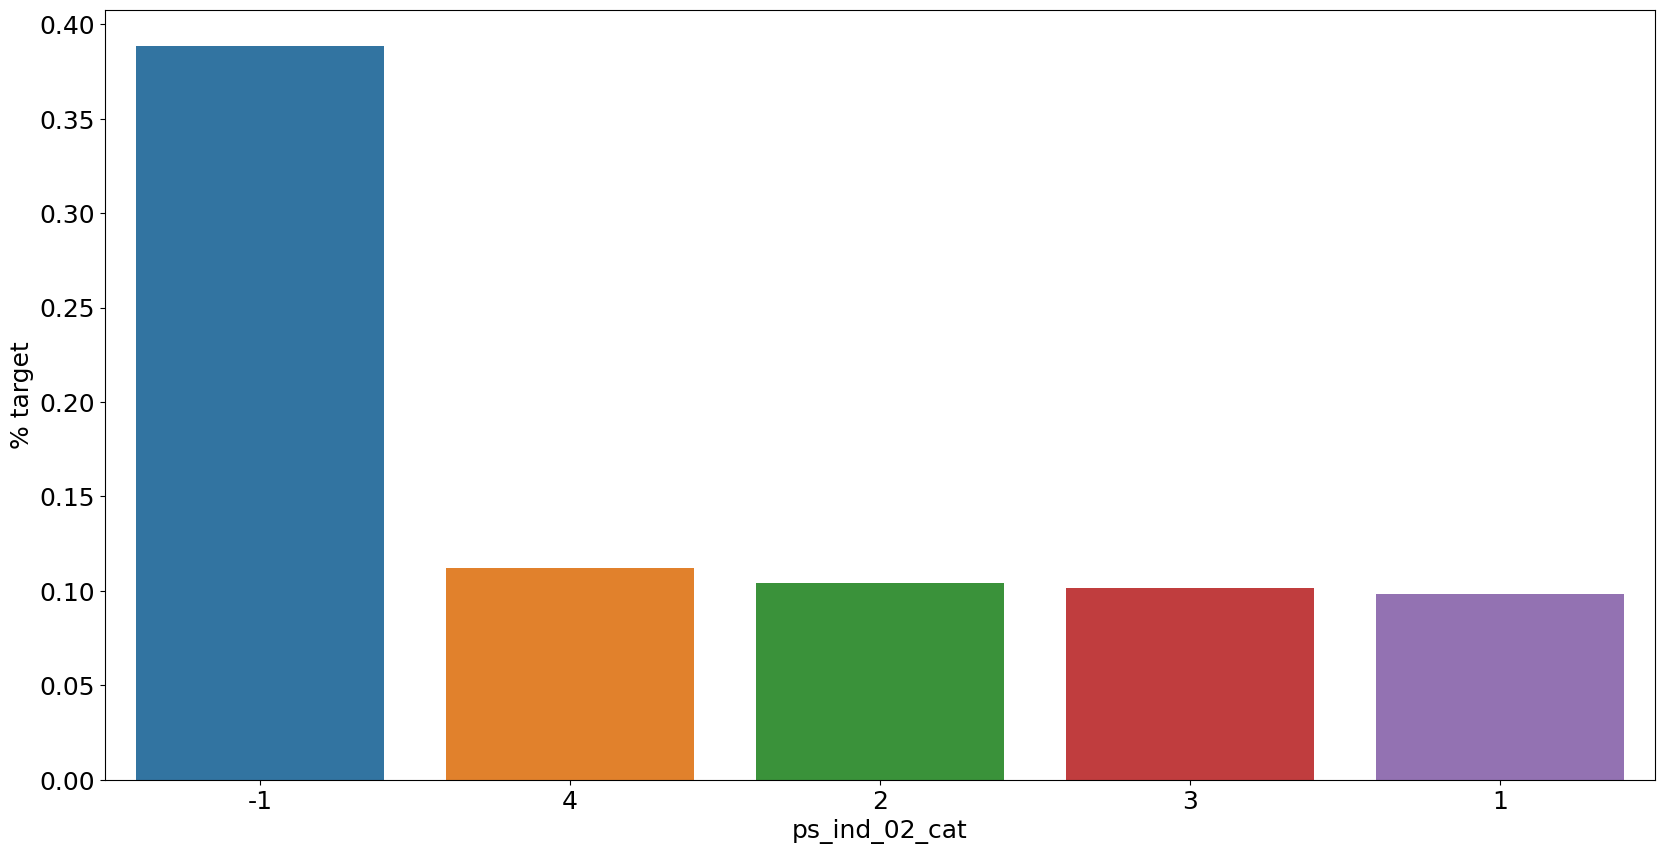

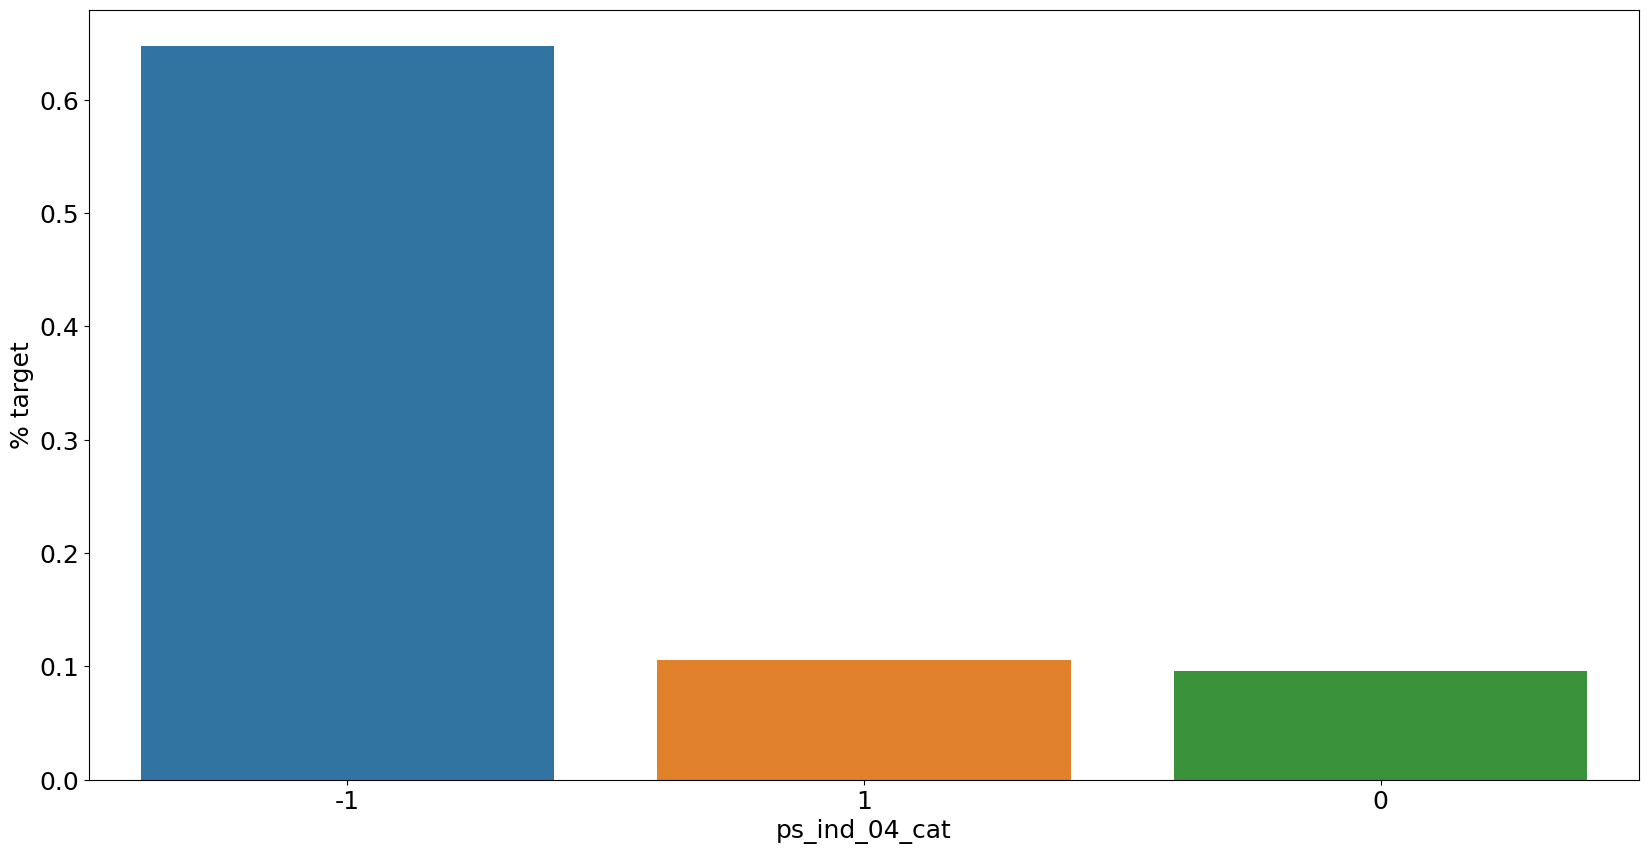

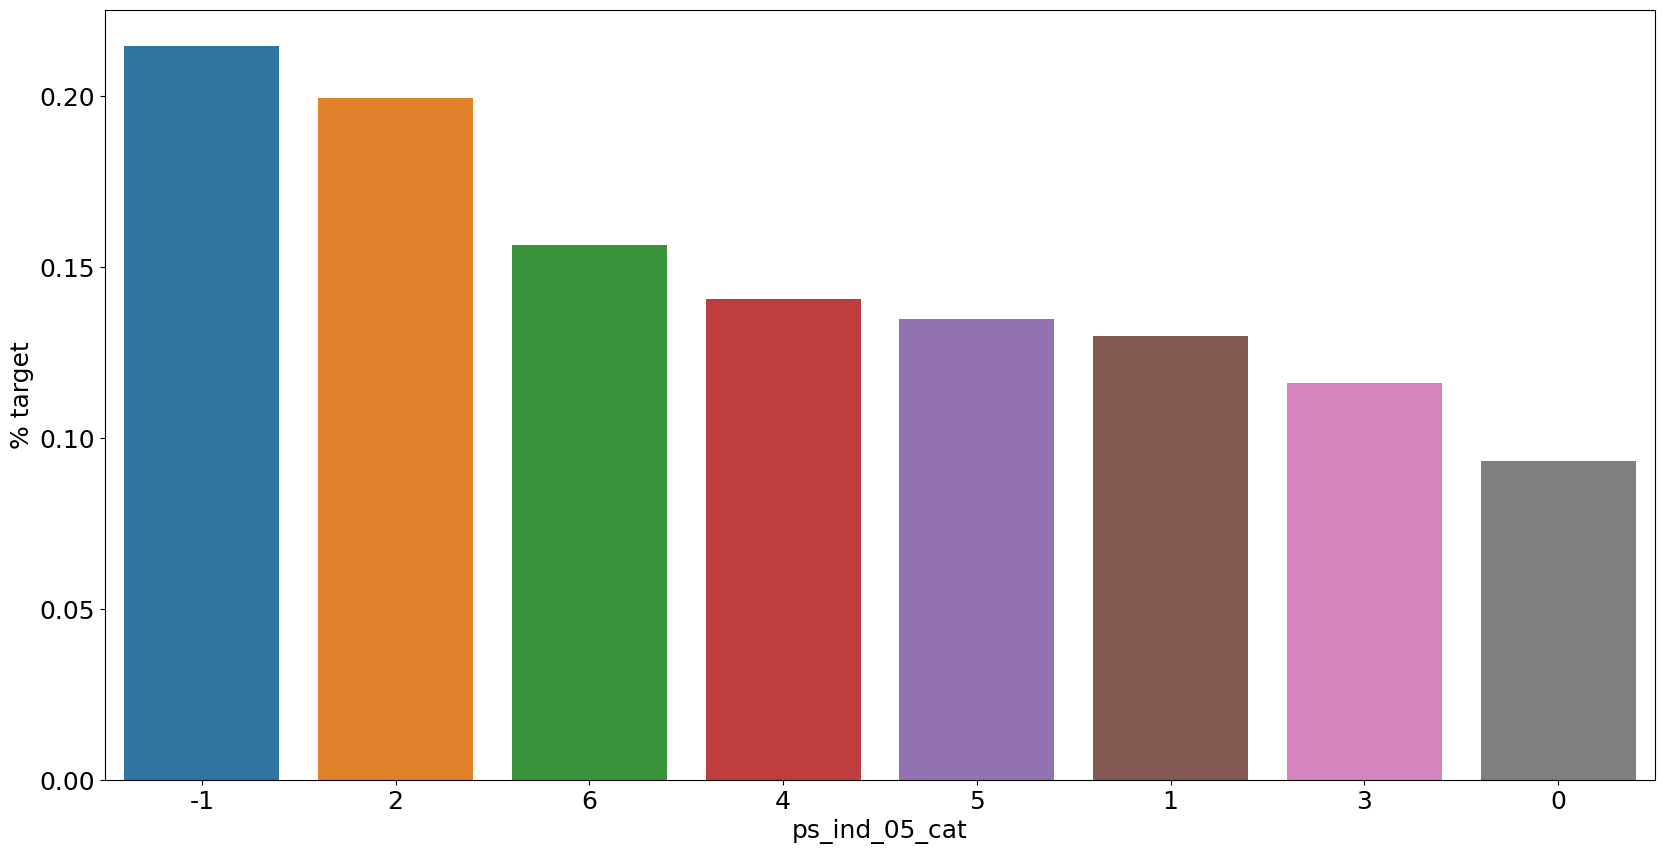

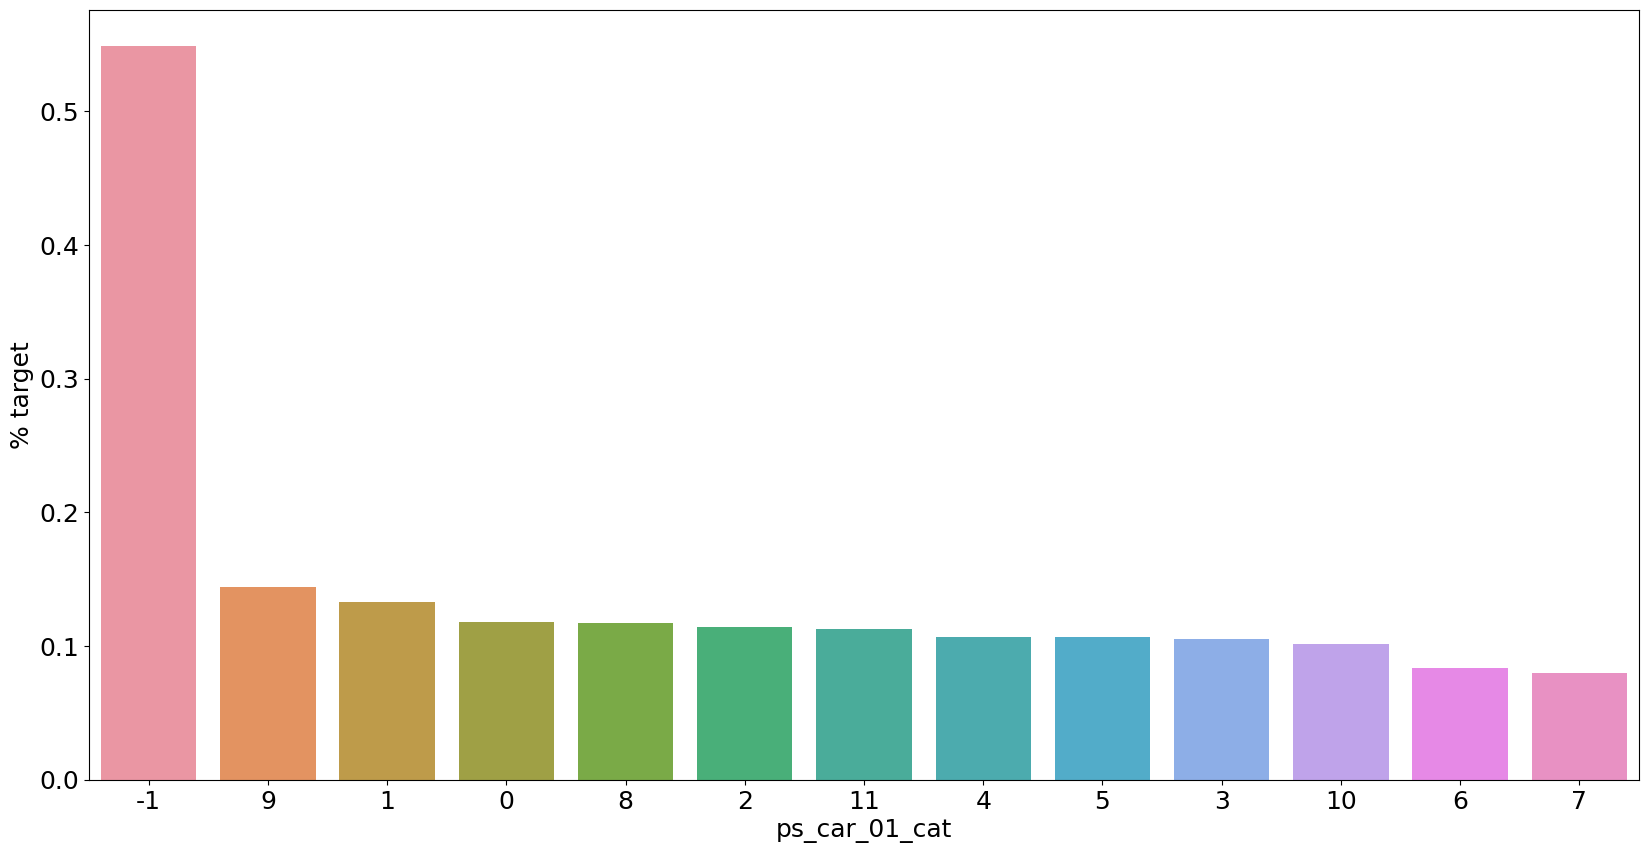

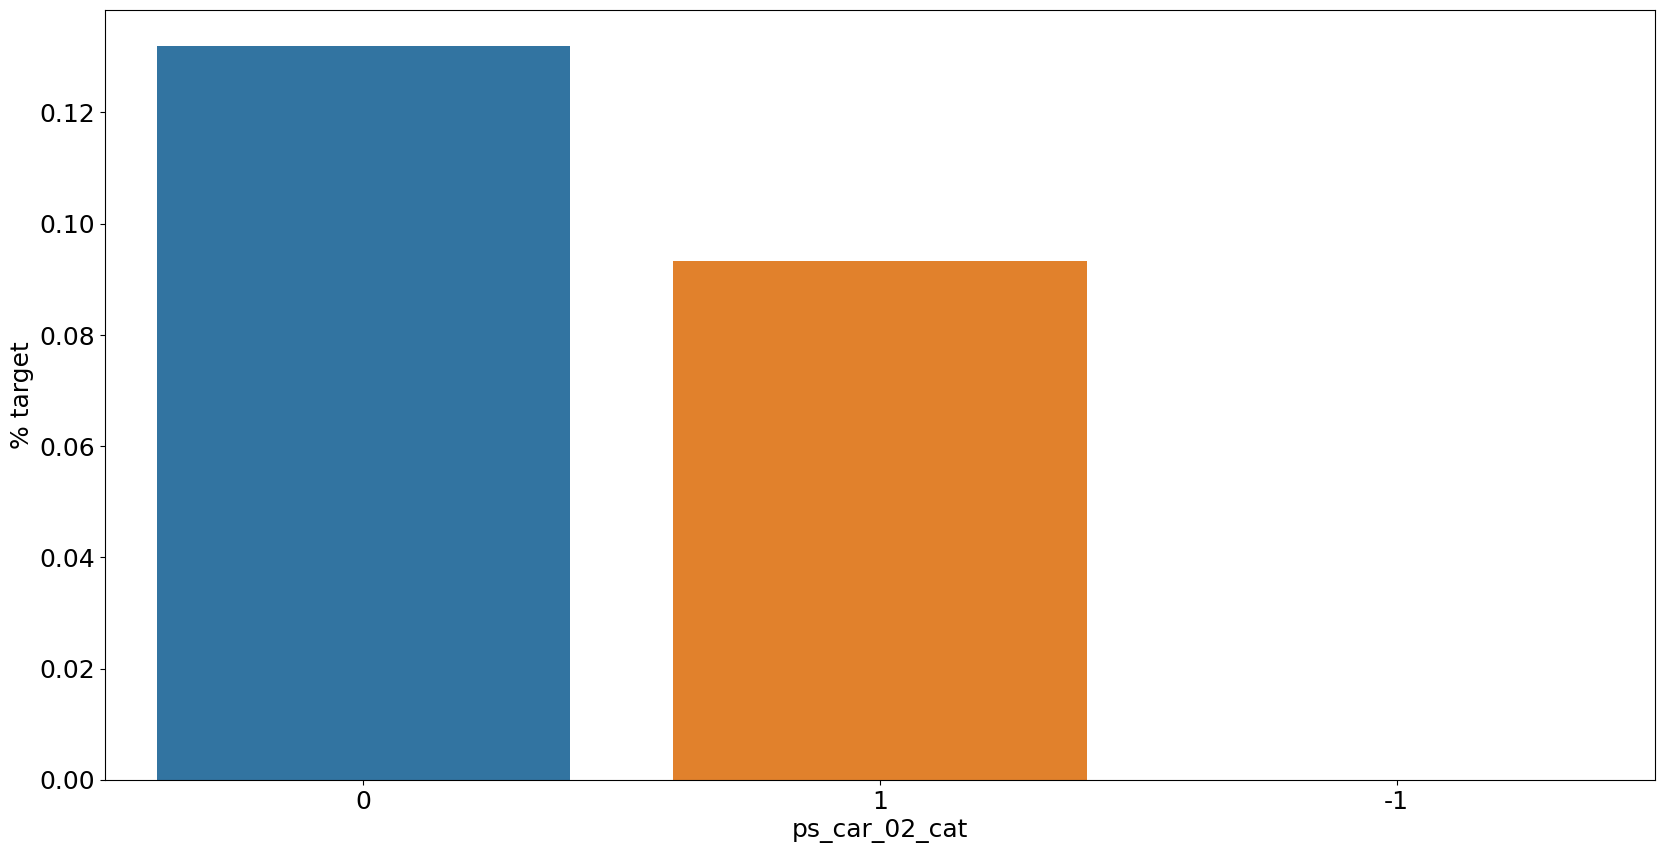

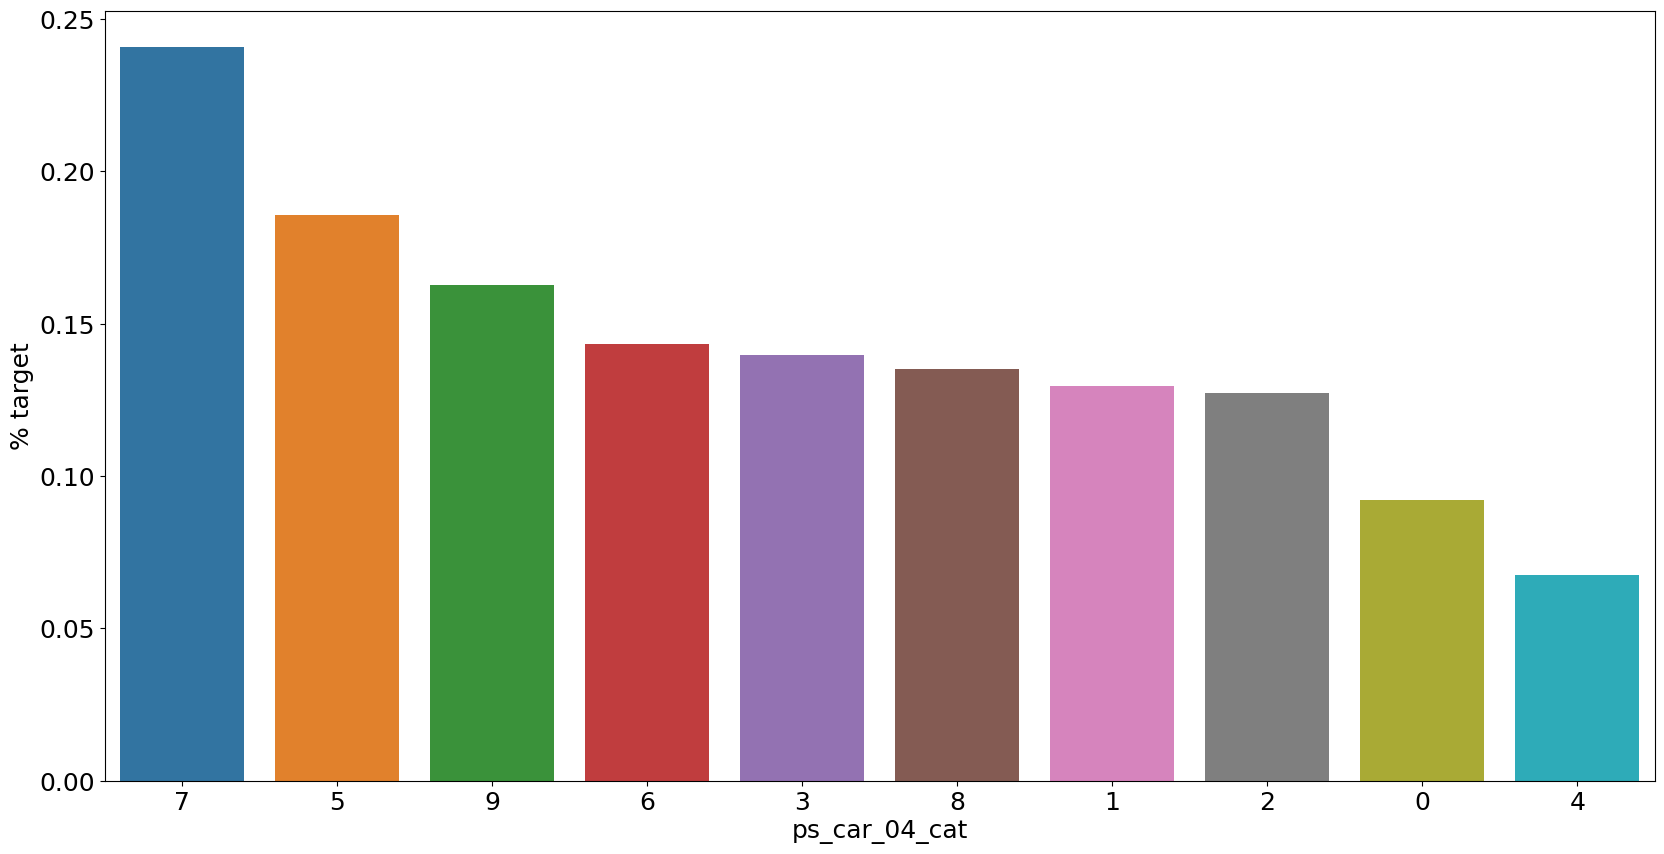

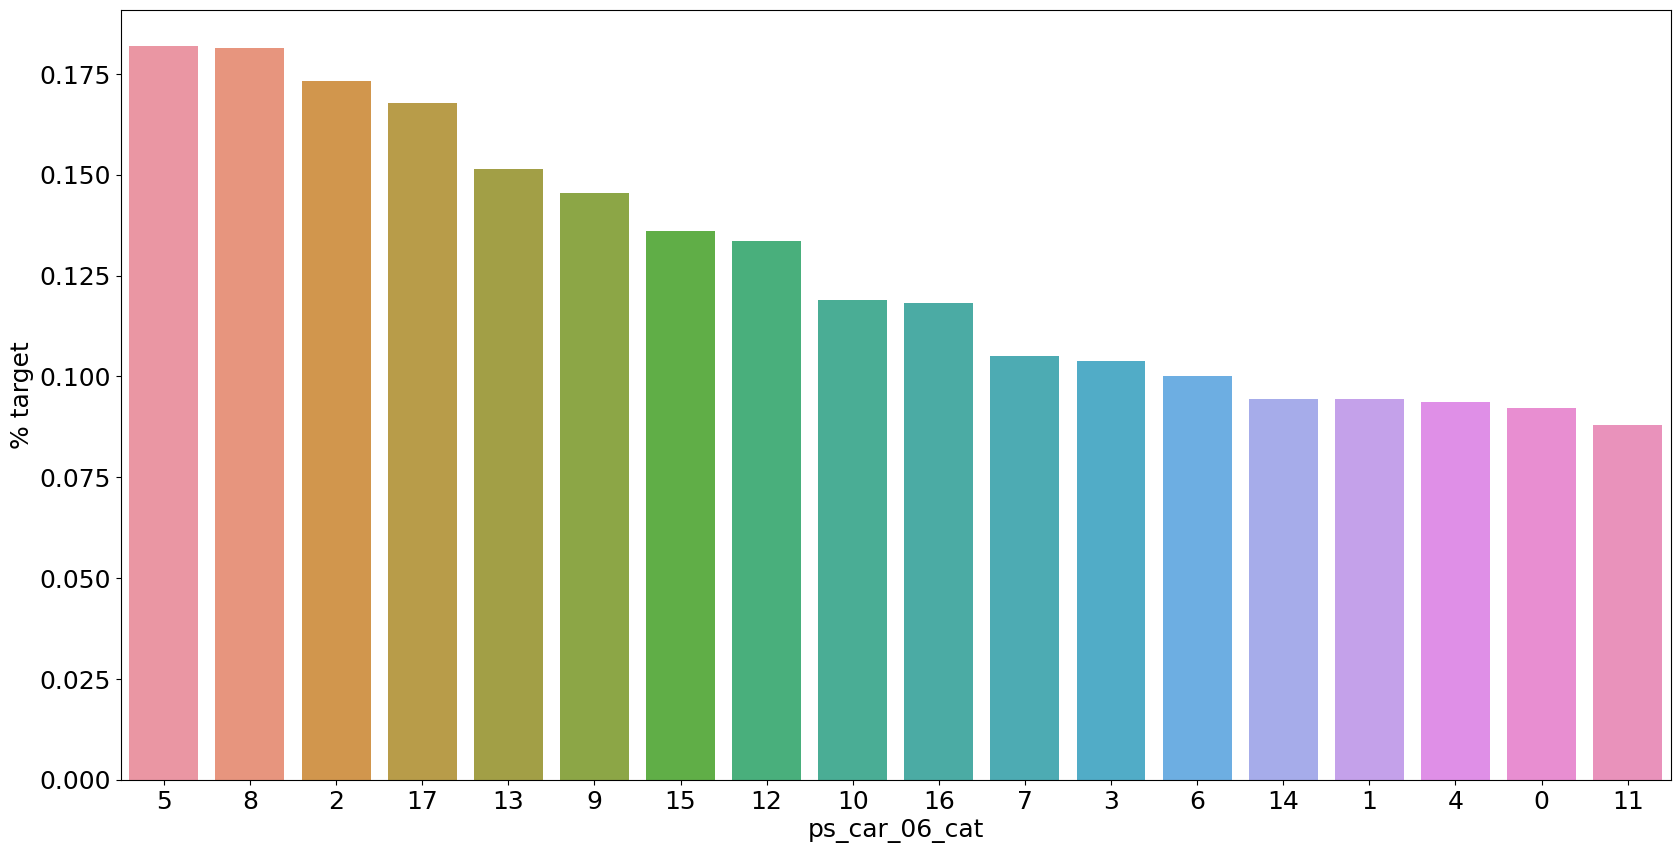

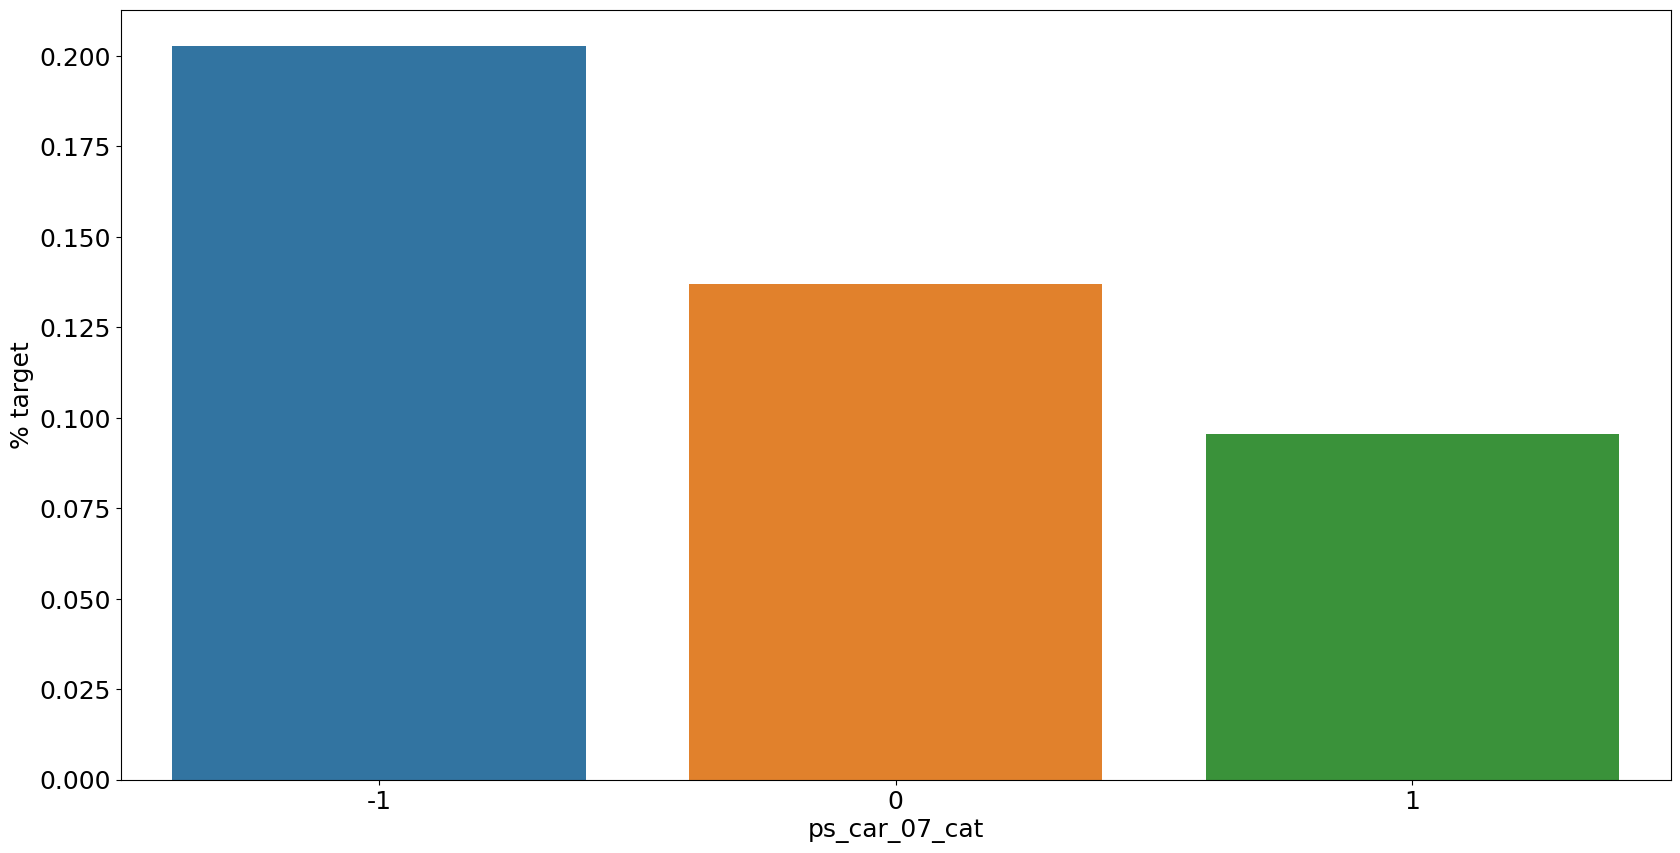

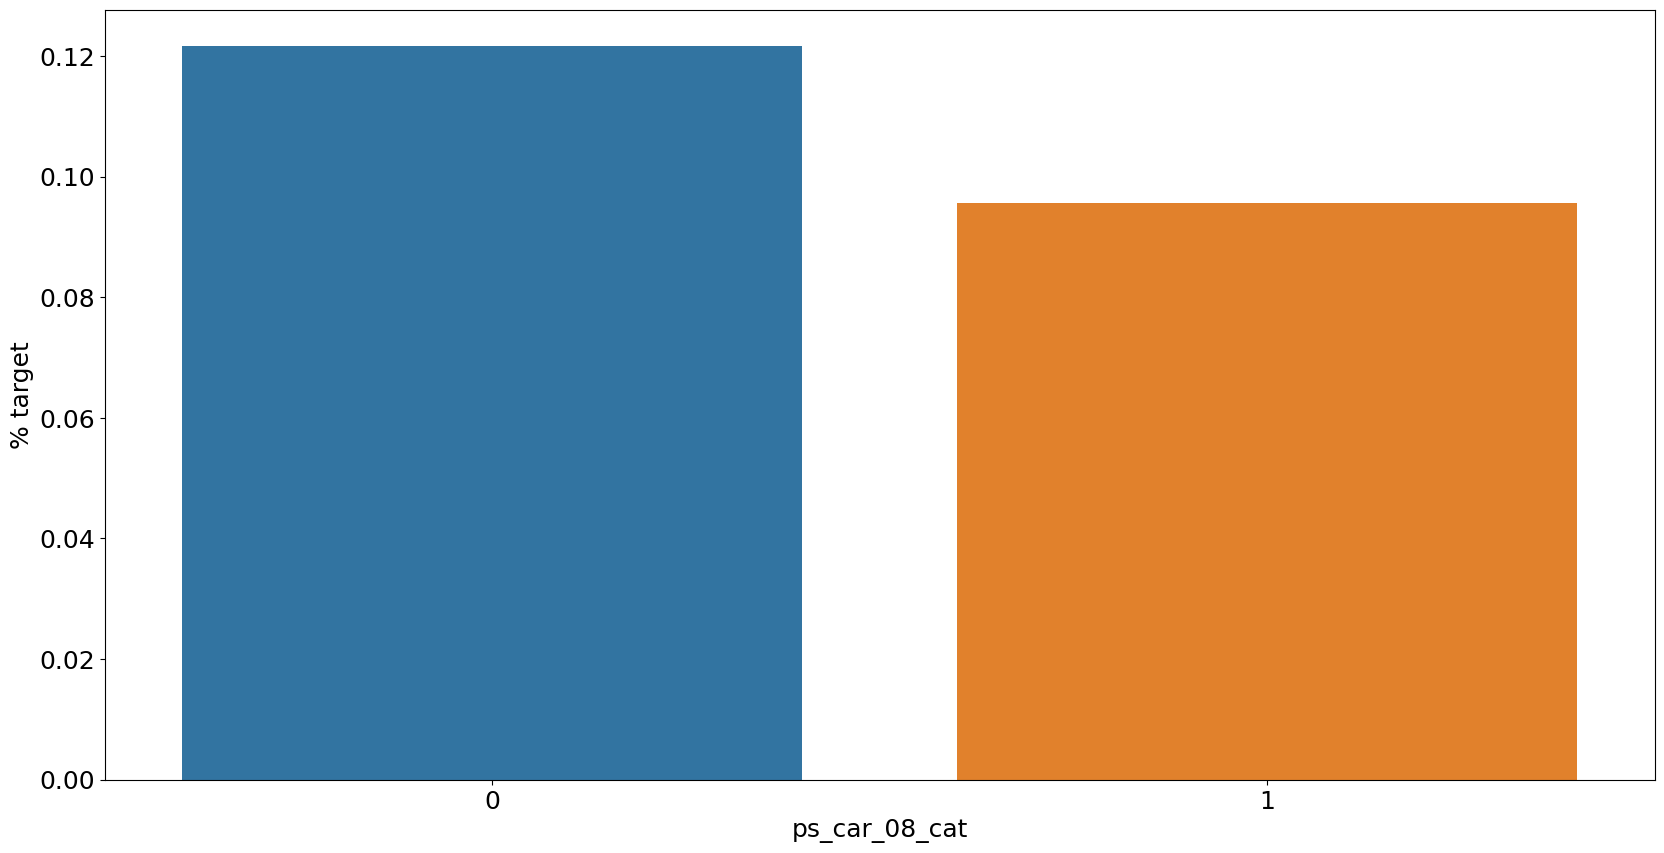

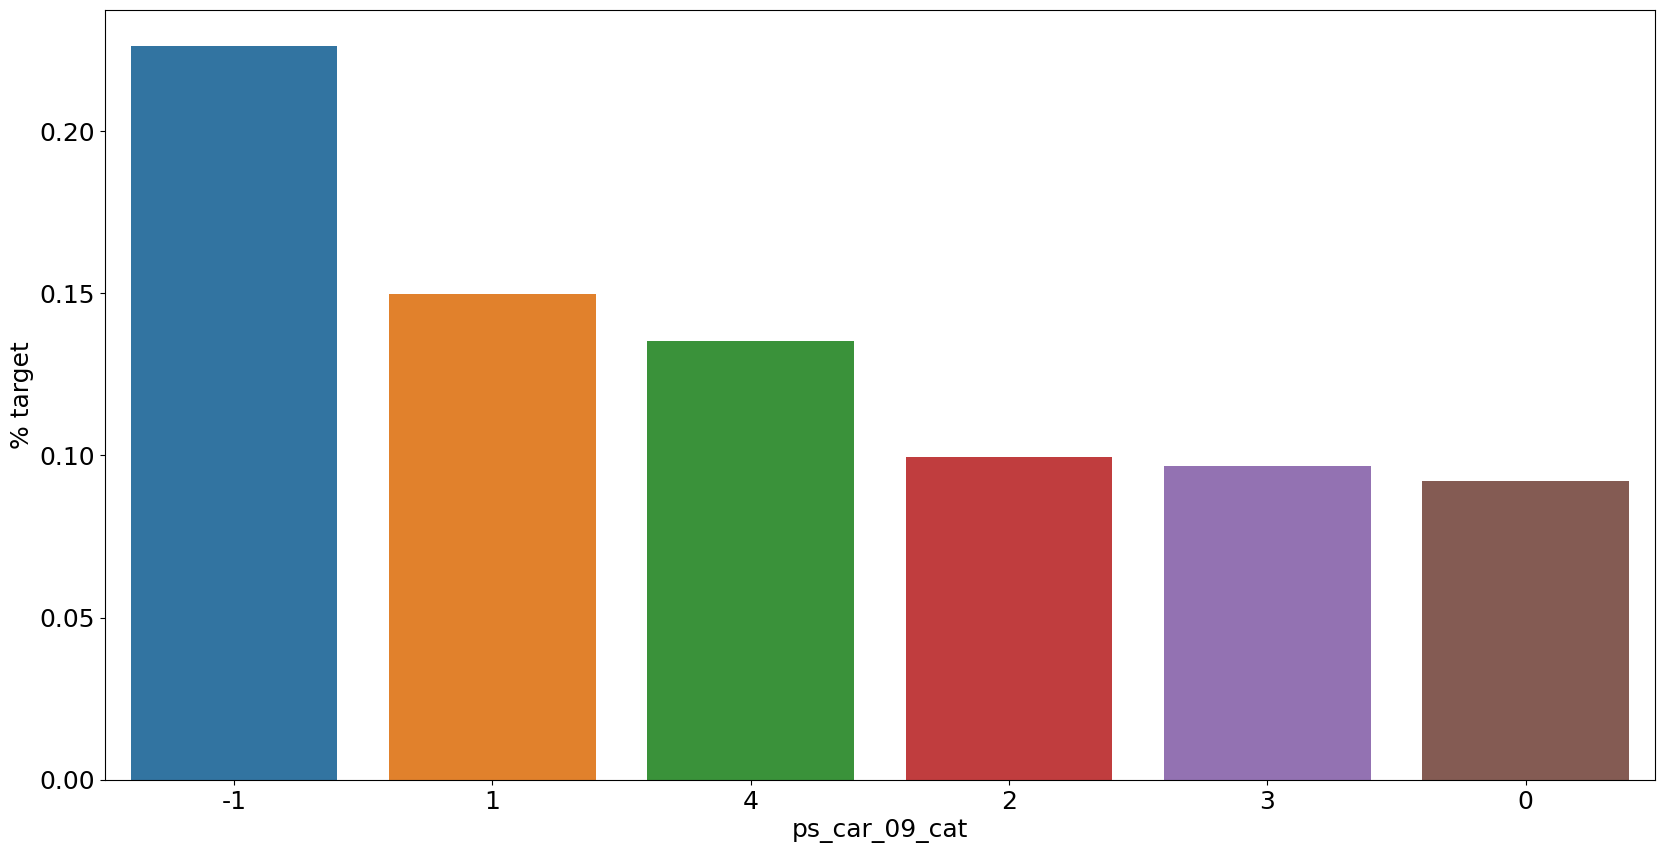

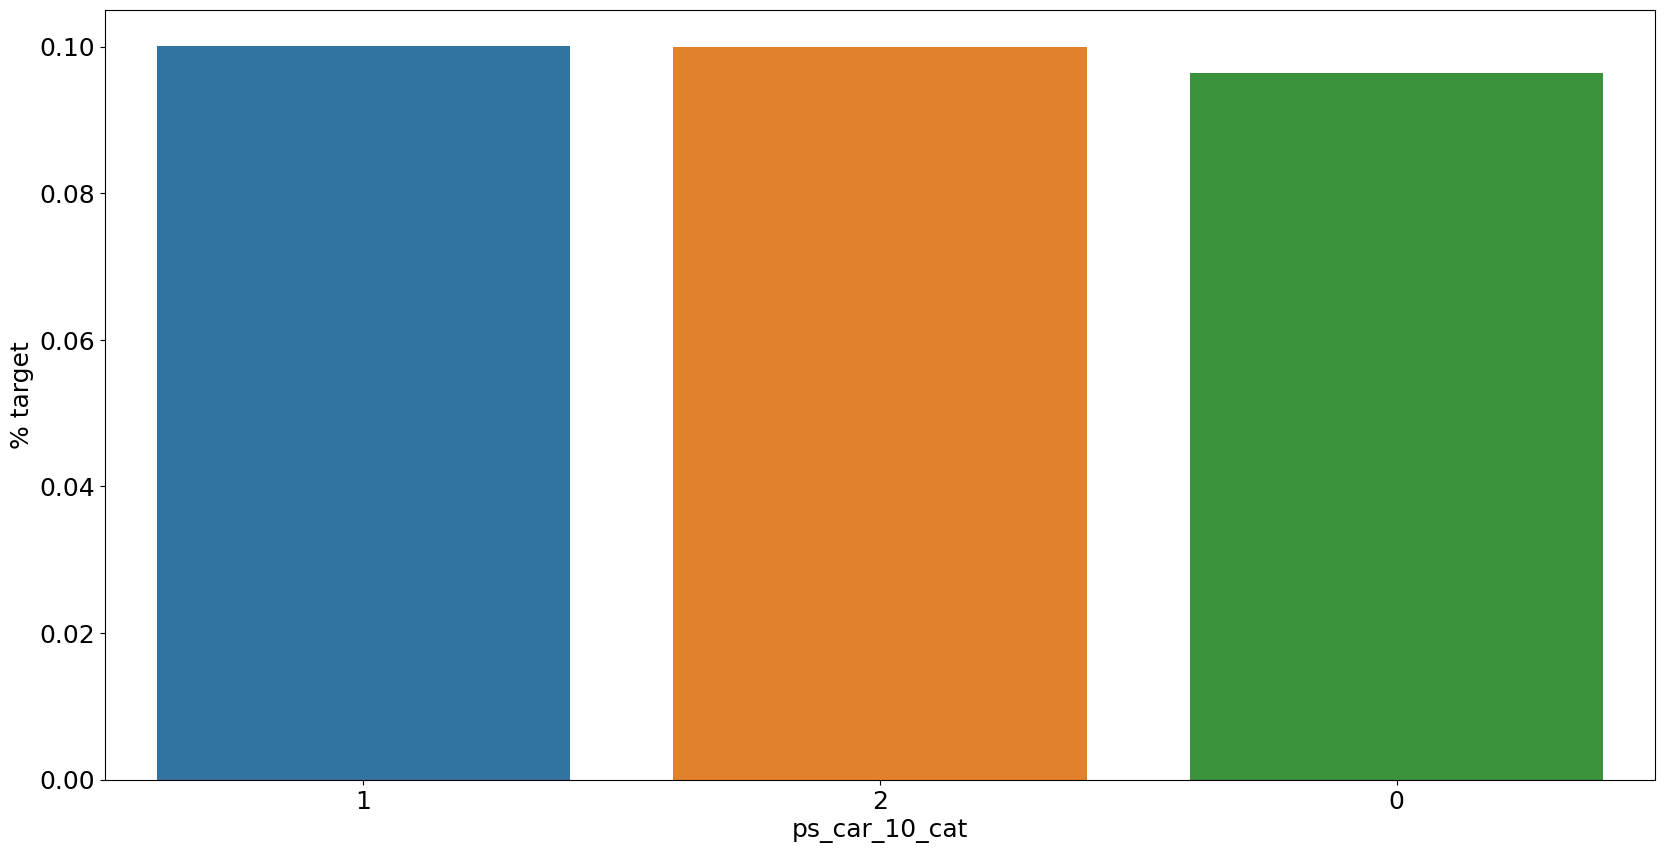

In [18]:
## Categorical variables
v = meta[(meta.level=='nominal')&(meta.keep)].index
# v = ['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
#        'ps_car_02_cat', 'ps_car_04_cat', 'ps_car_06_cat', 'ps_car_07_cat',
#        'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat']

for f in v:
    plt.figure(figsize=(20,10))
    ## Calculate the percentage of target=1 per category value
    cat_perc = train[[f, 'target']].groupby([f], as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    ## Bar plot
    ## Order the bars descending on target mean
    sns.barplot(x=f, y='target', data=cat_perc, order=cat_perc[f])
    plt.ylabel('% target', fontsize=18)
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.show();

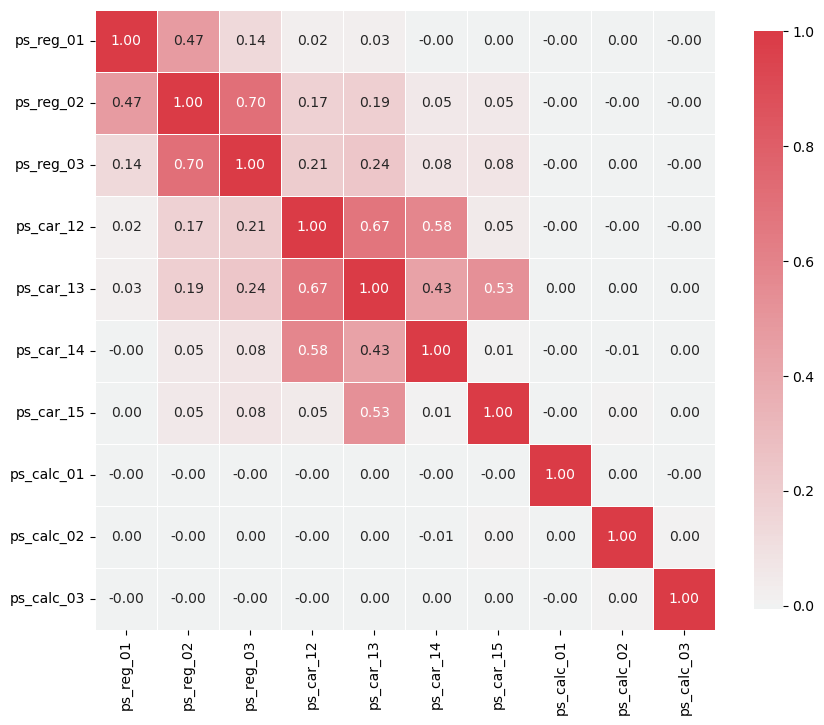

In [19]:
## Interval variables

def corr_heatmap(v):
    correlations = train[v].corr()

    ## Create color map ranging between two colors
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f', 
                square=True, linewidths=.5, annot=True, cbar_kws={'shrink':.75})
                # vmax: cmap의 최댓값, square: 그래프를 정사각형으로, annot: 각 셀에 문자 기입 
    plt.show();

v = meta[(meta.level=='interval')&(meta.keep)].index
corr_heatmap(v)
# 똑같이 따라했는데 상관관계가 차이난다. Imputer 함수가 바껴서 그런가??

There are a strong correlations between the variables:  
  
- ps_reg_02 and ps_reg_03 (0.7)
- ps_car_12 and ps_car13 (0.67)
- ps_car_12 and ps_car14 (0.58)
- ps_car_13 and ps_car15 (0.67)
  
Seaborn has some handy plots to visualize the (linear) relationship between variables. We could use a pairplot to visualize the relationship between the variables. But because the heatmap already showed the limited number of correlated variables, we'll look at each of the highly correlated variables separately.  
__NOTE__: I take a sample of the train data to speed up the process.

In [20]:
s = train.sample(frac=0.1)
# df.sample(n:int(return 개수), frac: float(return 비율), replace: bool(중복 추출), weights: str or array(가중치, 레이블마다 추출될 확률))

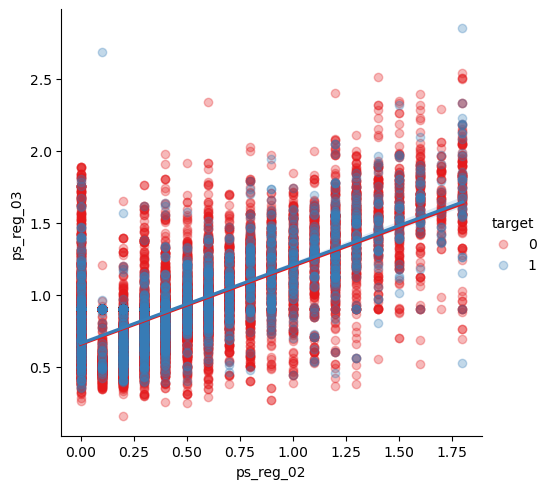

In [21]:
sns.lmplot(data=s, x='ps_reg_02', y='ps_reg_03', hue='target', palette='Set1', scatter_kws={'alpha': 0.3})
plt.show;

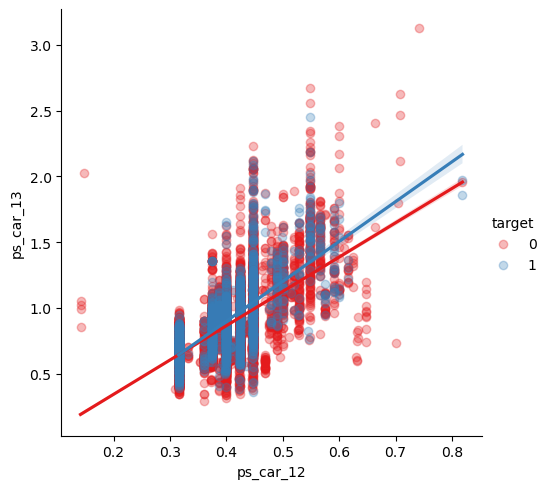

In [22]:
sns.lmplot(data=s, x='ps_car_12', y='ps_car_13', hue='target', palette='Set1', scatter_kws={'alpha': 0.3})
plt.show()

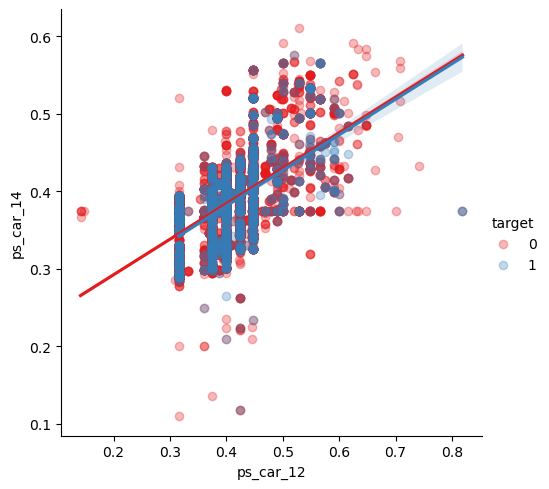

In [23]:
sns.lmplot(data=s, x='ps_car_12', y='ps_car_14', hue='target', palette='Set1', scatter_kws={'alpha': 0.3})
plt.show()

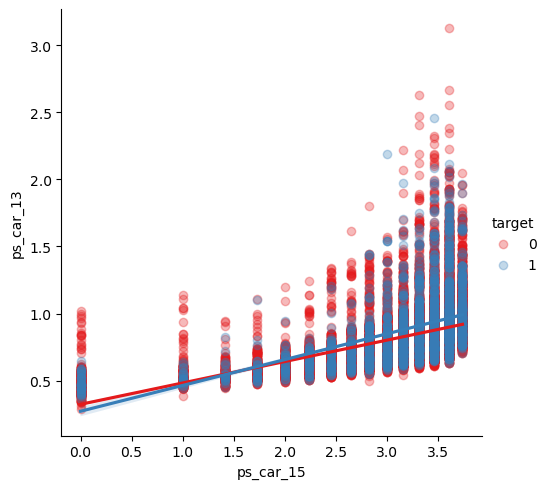

In [24]:
sns.lmplot(data=s, x='ps_car_15', y='ps_car_13', hue='target', palette='Set1', scatter_kws={'alpha': 0.3})
plt.show()

Allright, so now what? How can we decide which of the correlated variables to keep? We could perform Principal Component Analysis (PCA) on the variables to reduce the dimensions. In the AllState Claims Severity Competition I made [this kernel](https://www.kaggle.com/code/bertcarremans/reducing-number-of-numerical-features-with-pca/notebook) to do that. But as the number of correlated variables is rather low, we will let the model do the heavy-lifting.

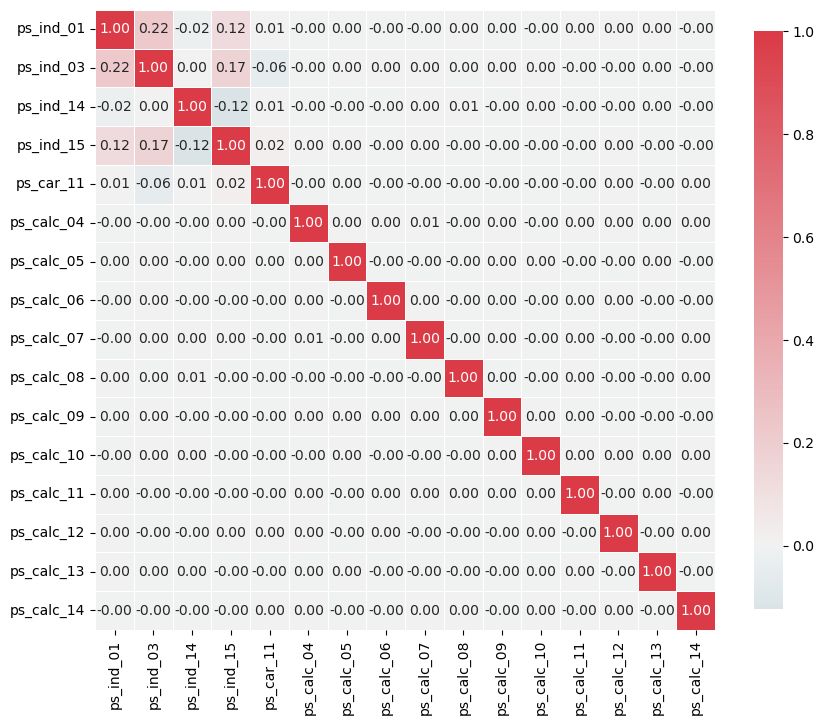

In [25]:
## Checking the correlations between ordinal variables
v = meta[(meta.level=='ordinal')&(meta.keep)].index
corr_heatmap(v)

### Feature engineering
  
__Creating dummy cariables__  
The values of the categorical variables do not represent any order or magnitude. For instance, category 2 is not twice the value of category 1. Therefore we can create dummy variables to deal with that. We drop the first dummy variable as this information can be derived from the other dummy variables generated for the categories of the original variable.

In [26]:
v = meta[(meta.level=='nominal')&(meta.keep)].index
print(f'Before dummification we have {train.shape[1]} variables in train')
train = pd.get_dummies(train, columns=v, drop_first=True)
# pd.get_dumies: 더미 변수 생성(원핫인코딩)
print(f'After dummification we have {train.shape[1]} variables in train')

Before dummification we have 57 variables in train
After dummification we have 109 variables in train


In [27]:
## Creating interaction variables
v = meta[(meta.level=='interval')&(meta.keep)].index
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
# PolynomialFeatures: 다항회귀, degree=차수, interaction_only=상호작용 피처 생성 여부, include_bias=상수(편향) 생성 여부
interactions = pd.DataFrame(data=poly.fit_transform(train[v]), columns=poly.get_feature_names_out(v))
interactions.drop(v, axis=1, inplace=True)  ## Remove the original columns
## Concat the interaction variables to the train data
print(f'Before creating interactions we have {train.shape[1]} variables in train')
train = pd.concat([train, interactions], axis=1)
# pd.get_dumies: 더미 변수 생성(원핫인코딩)
print(f'After creating interactions we have {train.shape[1]} variables in train')

Before creating interactions we have 109 variables in train
After creating interactions we have 164 variables in train


### Feature selection
__Removing features with low or zero variance__  
  
Personally, I prefer to let the classifier algorithm chose which features to keep. But there is one thing that we can do ourselves. That is removing features with no or a very low variance. Sklearn has a handy method to do that: __VarianceThreshold__. By default it removes features with zero variance. This will not be applicable for this competition as we saw there are no zero-variance variables in the previous steps. But if we would remove features with less than 1% variance, we would remove 31 variables.

### DeepL 번역
  
__분산이 낮거나 0인 특징 제거하기__
  
개인적으로 저는 분류기 알고리즘이 어떤 특징을 유지할지 선택하게 하는 것을 선호합니다. 하지만 우리가 직접 할 수 있는 일이 한 가지 있습니다. 분산이 없거나 매우 낮은 특징을 제거하는 것입니다. Sklearn에는 이를 위한 편리한 방법이 있습니다: __VarianceThreshold__. 기본적으로 분산이 0인 피처를 제거합니다. 이전 단계에서 분산이 0인 변수가 없다는 것을 확인했기 때문에 이 대회에는 적용되지 않습니다. 하지만 분산이 1% 미만인 특징을 제거하면 31개의 변수가 제거됩니다.

In [28]:
selector = VarianceThreshold(threshold=.01) # 분산이 threshold보다 작은 열 제거
selector.fit(train.drop(['id', 'target'], axis=1))  ## Fit to train without id and target variables

f = np.vectorize(lambda x: not x)   ## Fuction to toggle boolean array elements

v = train.drop(['id', 'target'], axis=1).columns[f(selector.get_support())]
print(f'{len(v)} variables have too low variance.')
print(f'These variables are {list(v)}')

28 variables have too low variance.
These variables are ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_12', 'ps_car_14', 'ps_car_11_cat_te', 'ps_ind_05_cat_2', 'ps_ind_05_cat_5', 'ps_car_01_cat_1', 'ps_car_01_cat_2', 'ps_car_04_cat_3', 'ps_car_04_cat_4', 'ps_car_04_cat_5', 'ps_car_04_cat_6', 'ps_car_04_cat_7', 'ps_car_06_cat_2', 'ps_car_06_cat_5', 'ps_car_06_cat_8', 'ps_car_06_cat_12', 'ps_car_06_cat_16', 'ps_car_06_cat_17', 'ps_car_09_cat_4', 'ps_car_10_cat_1', 'ps_car_10_cat_2', 'ps_car_12^2', 'ps_car_12 ps_car_14', 'ps_car_14^2']


We would lose rather many variables if we would select based on variance. But because we do not have so many variables, we'll let the classifier chose. For data sets with many more variables this could reduce the processing time.  
  
Sklearn also comes with other feature selection methods. One of these methods is SelectFromModel in which you let another classifier select the best features and continue with these. Below I'll show you how to do that with a Random Forest.  
  
__DeepL 번역__  
분산에 따라 선택하면 많은 변수를 잃게 됩니다. 하지만 변수가 많지 않기 때문에 분류기가 선택하도록 하겠습니다. 더 많은 변수가 있는 데이터 집합의 경우 처리 시간을 줄일 수 있습니다.  
  
Sklearn에는 다른 특징 선택 방법도 있습니다. 이러한 방법 중 하나는 다른 분류자가 최상의 특징을 선택하도록 하고 계속 진행하도록 하는 SelectFromModel입니다. 아래에서는 무작위 포리스트를 사용하여 이를 수행하는 방법을 보여드리겠습니다.

### Selecting features with a Random Forest and SelectFromModel
Here we'll base feature selection on the feature importances of a random forest. With Sklearn's SelectFromModel you can then specify how many variables you want to keep. You can set a threshold on the level of feature importance manually. But we'll simply select the top 50% best variables.  
  
The code in the cell below is borrowed from the GitHub repo of Sebastian Raschka. This repo contains code samples of his book Python Machine Learning, which is an absolute must to read.  
  
__DeepL 번역__  
여기서는 Random Forest의 기능 중요도에 따라 기능을 선택하겠습니다. 그런 다음 Sklearn의 SelectFromModel을 사용하여 유지하려는 변수의 수를 지정할 수 있습니다. 기능 중요도 수준에 대한 임계값을 수동으로 설정할 수 있습니다. 하지만 여기서는 단순히 상위 50%의 가장 좋은 변수를 선택하겠습니다.  
  
아래 셀의 코드는 Sebastian Raschka의 GitHub 리포지토리에서 빌려온 것입니다. 이 리포지토리에는 그의 저서 Python Machine Learning의 코드 샘플이 포함되어 있으므로 꼭 읽어보시기 바랍니다.


In [29]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']

feat_labels = X_train.columns

rf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

rf.fit(X_train, y_train)
importances = rf.feature_importances_

indices = np.argsort(rf.feature_importances_)[::-1] # step=-1로 내림차순 정렬

for f in range(X_train.shape[1]):
    print('%2d) %-*s %f' % (f+1, 30, feat_labels[indices[f]], importances[indices[f]]))
    # print(f'{f+1}) %-*s %f' % (f+1, 30, feat_labels[indices[f]], importances[indices[f]]))

 1) ps_car_11_cat_te               0.021113
 2) ps_car_13                      0.017374
 3) ps_car_12 ps_car_13            0.017281
 4) ps_car_13^2                    0.017247
 5) ps_car_13 ps_car_14            0.017157
 6) ps_reg_03 ps_car_13            0.017090
 7) ps_reg_01 ps_car_13            0.016787
 8) ps_car_13 ps_car_15            0.016753
 9) ps_reg_03 ps_car_14            0.016239
10) ps_reg_03 ps_car_12            0.015560
11) ps_reg_03 ps_car_15            0.015144
12) ps_car_14 ps_car_15            0.015086
13) ps_car_13 ps_calc_03           0.014704
14) ps_reg_02 ps_car_13            0.014693
15) ps_car_13 ps_calc_01           0.014680
16) ps_reg_01 ps_reg_03            0.014674
17) ps_car_13 ps_calc_02           0.014652
18) ps_reg_01 ps_car_14            0.014396
19) ps_reg_03                      0.014255
20) ps_reg_03^2                    0.014251
21) ps_reg_03 ps_calc_03           0.013783
22) ps_reg_03 ps_calc_01           0.013749
23) ps_reg_03 ps_calc_02        

In [30]:
sfm = SelectFromModel(rf, threshold='median', prefit=True)
print(f'Number of features before selection: {X_train.shape[1]}')
n_features = sfm.transform(X_train).shape[1]
print(f'Number of features after selection: {n_features}')
selected_vars = list(feat_labels[sfm.get_support()])

Number of features before selection: 162


c:\Users\why\miniconda3\envs\study\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Number of features after selection: 81


In [31]:
train = train[selected_vars+['target']]
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216940 entries, 0 to 216939
Data columns (total 82 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ps_ind_01              216940 non-null  int64  
 1   ps_ind_03              216940 non-null  int64  
 2   ps_ind_15              216940 non-null  int64  
 3   ps_reg_01              216940 non-null  float64
 4   ps_reg_02              216940 non-null  float64
 5   ps_reg_03              216940 non-null  float64
 6   ps_car_11              216940 non-null  int64  
 7   ps_car_12              216940 non-null  float64
 8   ps_car_13              216940 non-null  float64
 9   ps_car_14              216940 non-null  float64
 10  ps_car_15              216940 non-null  float64
 11  ps_calc_01             216940 non-null  float64
 12  ps_calc_02             216940 non-null  float64
 13  ps_calc_03             216940 non-null  float64
 14  ps_calc_04             216940 non-nu

### Feature scaling
  
As mentioned before, we can apply standard scaling to the training data. Some classifiers perform better when this is done.

In [32]:
scaler = StandardScaler()
scaler.fit_transform(train.drop(['target'], axis=1))

array([[-0.45941104, -1.26665356,  1.05087653, ..., -0.72553616,
        -1.01071913, -1.06173767],
       [ 1.55538958,  0.95034274, -0.63847299, ..., -1.06120876,
        -1.01071913,  0.27907892],
       [ 1.05168943, -0.52765479, -0.92003125, ...,  1.95984463,
        -0.56215309, -1.02449277],
       ...,
       [-0.9631112 ,  0.58084336,  0.48776003, ..., -0.46445747,
         0.18545696,  0.27907892],
       [-0.9631112 , -0.89715418, -1.48314775, ..., -0.91202093,
        -0.41263108,  0.27907892],
       [-0.45941104, -1.26665356,  1.61399304, ...,  0.28148164,
        -0.11358706, -0.72653353]])

In [33]:
scaler

StandardScaler()

## Conclusion
Hopefully this notebook helped you with some tips on how to start with this competition. Feel free to vote for it. And if you have questions, post a comment.

# [Interactive Porto Insights - A Plot.ly Tutorial](https://www.kaggle.com/code/arthurtok/interactive-porto-insights-a-plot-ly-tutorial/notebook)
  
## Introduction
This competition is hosted by the third largest insurance company in Brazil: Porto Seguro with the task of predicting the probability that a driver will initiate an insurance claim in the next year.  
  
This notebook will aim to provide some interactive charts and analysis of the competition data by way of the Python visualisation library Plot.ly and hopefully bring some insights and beautiful plots that others can take and replicate. Plot.ly is one of the main products offered by the software company - Plotly which specializes in providing online graphical and statistical visualisations (charts and dashboards) as well as providing an API to a whole rich suite of programming languages and tools such as Python, R, Matlab, Node.js etc.  
  
Listed below for easy convenience are links to the various Plotly plots in this notebook:  
  
- Simple horizontal bar plot - Used to inspect the Target variable distribution
- Correlation Heatmap plot - Inspect the correlation between the different features
- Scatter plot - Compare the feature importances generated by Random Forest and Gradient-Boosted model
- Vertical bar plot - List in Descending order, the importance of the various features
- 3D Scatter plot
  
The themes in this notebook can be briefly summarized follows:

1. __Data Quality Checks__ - Visualising and evaluating all missing/Null values (values that are -1)

2. __Feature inspection and filtering__ - Correlation and feature Mutual information plots against the target variable. Inspection of the Binary, categorical and other variables.

3. __Feature importance ranking via learning models__ - Building a Random Forest and Gradient Boosted model to help us rank features based off the learning process.


## DeepL 번역
이 대회는 브라질에서 세 번째로 큰 보험 회사에서 주최합니다: 포르투 세구로가 주최하는 이 대회는 운전자가 내년에 보험금을 청구할 확률을 예측하는 과제를 가지고 있습니다.  
  
이 노트북은 Python 시각화 라이브러리인 Plot.ly를 통해 대회 데이터에 대한 대화형 차트와 분석을 제공하고, 다른 사람들이 가져와서 복제할 수 있는 인사이트와 멋진 플롯을 제공하는 것을 목표로 합니다. Plot.ly는 온라인 그래픽 및 통계 시각화(차트 및 대시보드)를 전문으로 제공하는 소프트웨어 회사인 Plotly에서 제공하는 주요 제품 중 하나이며, Python, R, Matlab, Node.js 등과 같은 다양한 프로그래밍 언어 및 도구에 대한 API를 제공합니다.  
  
편의를 위해 이 노트북에 있는 다양한 Plotly 플롯에 대한 링크를 아래에 나열해 두었습니다:  
  
- 간단한 가로 막대 그래프 - Target 변수 분포를 검사하는 데 사용됩니다.
- 상관 관계 히트맵 플롯 - 여러 피처 간의 상관 관계를 검사합니다.
- 산점도 - 랜덤 포레스트 및 그라디언트 부스트 모델에서 생성된 특징의 중요도를 비교합니다.
- 세로 막대형 차트 - 다양한 특징의 중요도를 내림차순으로 나열합니다.
- 3D 스캐터 플롯
  
이 노트북의 테마는 다음과 같이 간략하게 요약할 수 있습니다:  
  
1. __데이터 품질 검사__ - 모든 누락/무효 값(-1인 값) 시각화 및 평가

2. __특징 검사 및 필터링__ - 대상 변수에 대한 상관관계 및 특징 상호 정보 플롯. 이진, 범주형 및 기타 변수 검사.

3. __학습 모델을 통한 특징 중요도 순위 매기기__ - 학습 과정을 기반으로 특징의 순위를 매기는 데 도움이 되는 랜덤 포레스트 및 그라디언트 부스트 모델을 구축합니다.

In [34]:
## Let us load in the relevant Python modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# plotly도 matplotlib 같은 시각화 라이브러리. 아직 자세히는 모름.
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
# warnings.filterwarnings('ignore')

In [35]:
train = pd.read_csv('./input/porto-seguro-safe-driver-prediction/train.csv')
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [36]:
## Taking a look at how many rows and columns thr train dataset contains
rows = train.shape[0]
columns = train.shape[1]
print(f'The train dataset contains {rows} rows and {columns} columns.')

The train dataset contains 595212 rows and 59 columns.


### Data Quality checks
__Null or missing values check__  
  
As part of our quality checks, let us quick look at whether there are any null values in the train dataset as follows:

In [37]:
## any() applied twice to check run the isnull check across all columns.
# train.isnull().any()        # 각 열에 대하여
train.isnull().any().any()  # df 전체에 대하여

False

- Our null values check returns False but however, this does not really mean that this case has been closed as the data is also described as ["Values of -1 indicate that the feature was missing from the observation"](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data). Therefore I take it that Porto Seguro has simply conducted a blanket replacement of all null values in the data with the value of -1. Let us now inspect if there where any missing values in the data.

__DeepL 번역__  
- Null 값 검사는 False를 반환하지만, 데이터에 ["-1 값은 관찰에서 기능이 누락되었음을 나타냅니다"](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data).라고 설명되어 있으므로 실제로 이 사례가 닫혔다는 의미는 아닙니다. 따라서 포르투 세구로는 단순히 데이터의 모든 널 값을 -1 값으로 일괄 대체한 것으로 간주합니다. 이제 데이터에 누락된 값이 있는지 검사해 보겠습니다.

True


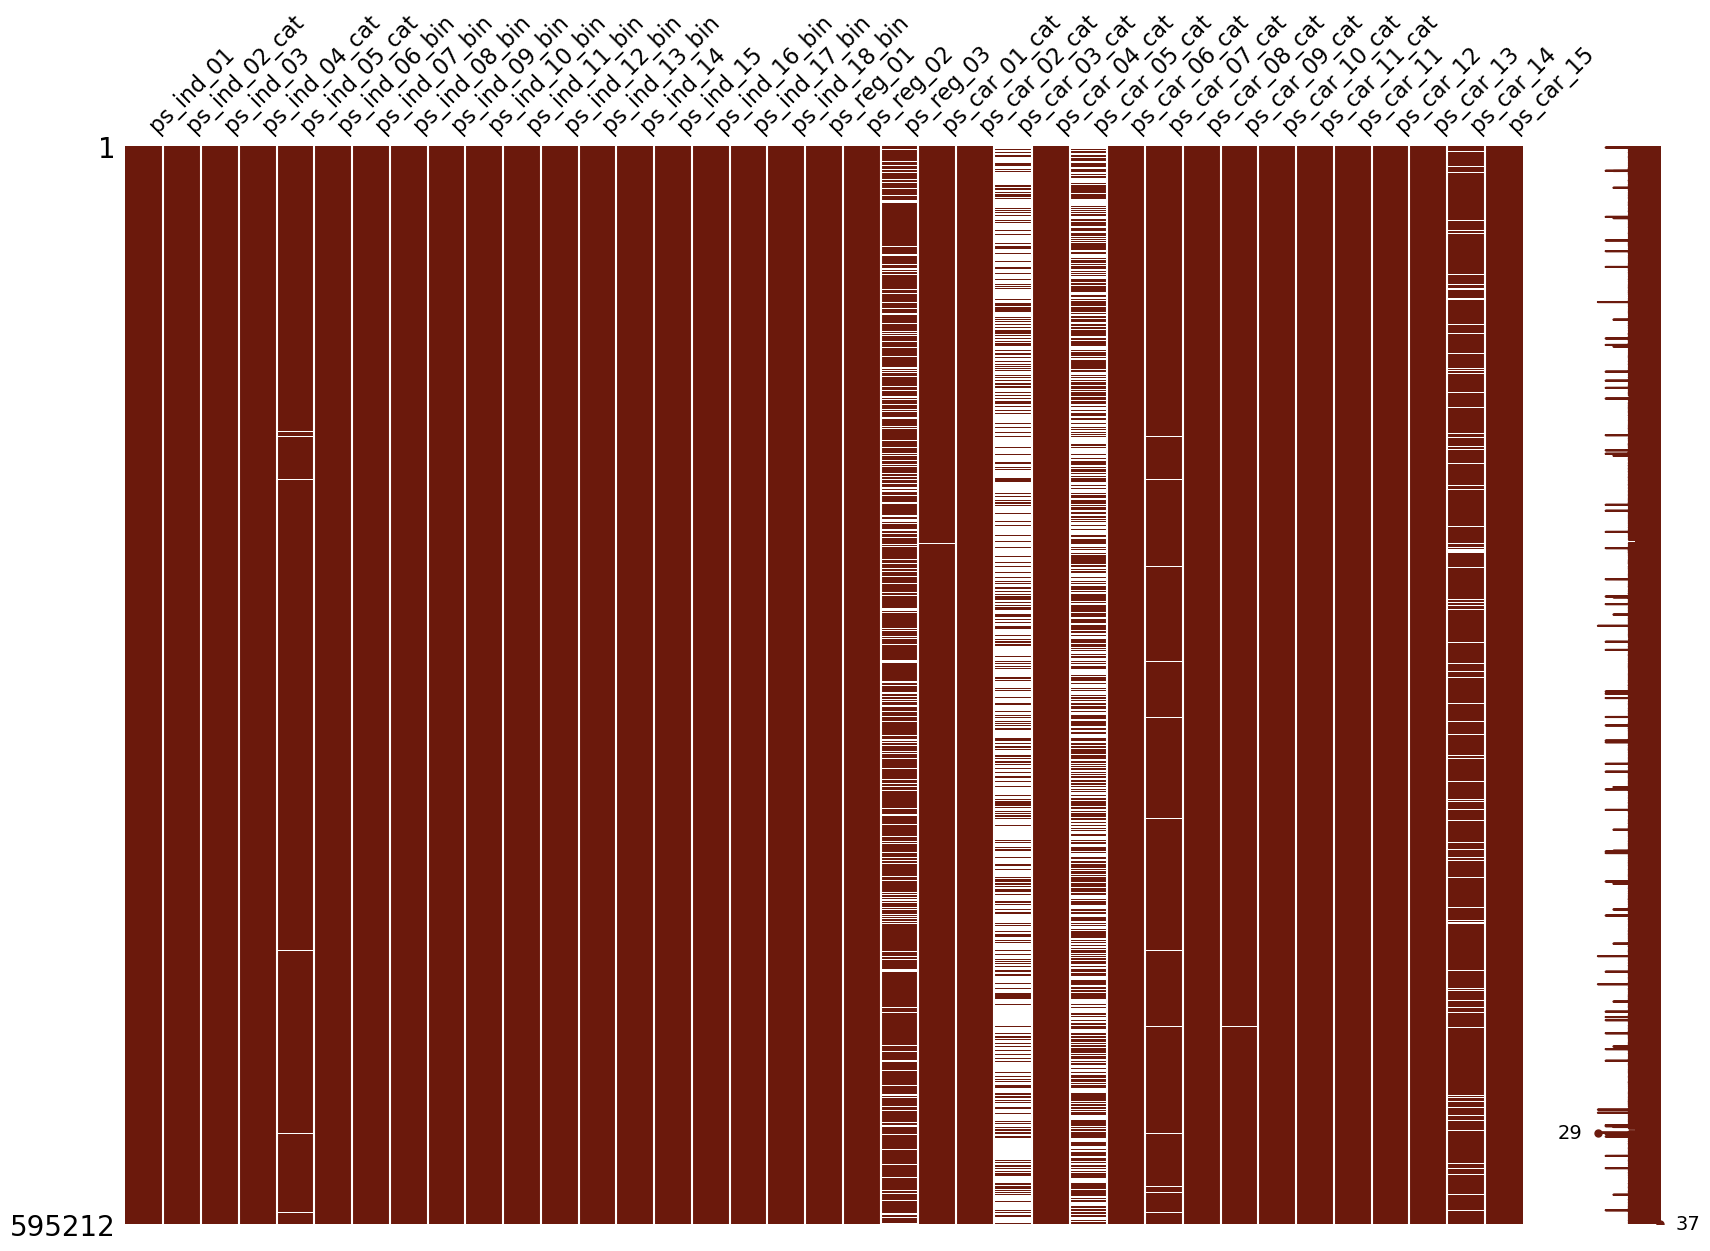

In [38]:
import missingno as msno

train_copy = train.replace(-1, np.NaN)
print(train_copy.isnull().any().any())
## Nullity or missing value by columns
msno.matrix(df=train_copy.iloc[:,2:39], figsize=(20,14), color=(0.42,0.1,0.05));

# ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']
# 그래프는 출력되지만 위와 같은 오류 발생 시 해결법.
# ~/env/Lib/site-packages/missingno/missingno.py에서 .grid(b=False)를 .grid(visible=False)로 변경 후 저장.
# matplotlib.axes._base.py에서 인자명이 변경됨.
# 출처: 스택오버플로우(https://stackoverflow.com/questions/75525029/msno-matrix-shows-an-error-when-i-use-any-venv-using-pyenv)


As we can see, the missing values now become much more apparent and clear when we visualise it, where the empty white bands (data that is missing) superposed on the vertical dark red bands (non-missing data) reflect the nullity of the data in that particular column. In this instance, we can observe that there are 7 features out of the 59 total features (although as rightly pointed out by Justin Nafe in the comments section there are really a grand total of 13 columns with missing values) that actually contained null values. This is due to the fact that the missingno matrix plot can only comfortable fit in approximately 40 odd features to one plot after which some columns may be excluded, and hence the remaining 5 null columns have been excluded. To visualize all nulls, try changing the figsize argument as well as tweaking how we slice the dataframe.  
  
For the 7 null columns that we are able to observe, they are hence listed here as follows:  
  
ps_ind_05_cat | ps_reg_03 | ps_car_03_cat | ps_car_05_cat | ps_car_07_cat | ps_car_09_cat | ps_car_14  
  
Most of the missing values occur in the columns suffixed with _cat. One should really take further note of the columns ps_reg_03, ps_car_03_cat and ps_car_05_cat. Evinced from the ratio of white to dark bands, it is very apparent that a big majority of values are missing from these 3 columns, and therefore a blanket replacement of -1 for the nulls might not be a very good strategy.  
  
__DeepL 번역__  
보시다시피, 이제 시각화하면 누락된 값이 훨씬 더 분명하고 명확해지며, 수직의 진한 빨간색 띠(누락되지 않은 데이터)에 겹쳐진 빈 흰색 띠(누락된 데이터)는 특정 열에 있는 데이터의 무효성을 반영합니다. 이 경우, 총 59개의 기능 중 7개의 기능이 실제로 결측값을 포함하고 있는 것을 관찰할 수 있습니다(댓글 섹션에서 Justin Nafe가 올바르게 지적했듯이 실제로 결측값이 있는 열은 총 13개입니다). 이는 누락이 없는 매트릭스 플롯이 약 40개의 홀수 피처만 하나의 플롯에 편안하게 맞출 수 있기 때문에 일부 열이 제외될 수 있으므로 나머지 5개의 null 열이 제외되었기 때문입니다. 모든 null을 시각화하려면 figsize 인수를 변경하고 데이터 프레임을 조각화하는 방법을 조정해 보십시오.  
  
따라서 관찰할 수 있는 7개의 null 열은 다음과 같이 나열되어 있습니다:  
  
PS_IND_05_CAT | PS_REG_03 | PS_CAR_03_CAT | PS_CAR_05_CAT | PS_CAR_07_CAT | PS_CAR_09_CAT | PS_CAR_14  
  
대부분의 누락된 값은 _cat이 접미사로 붙은 열에서 발생합니다. ps_reg_03, ps_car_03_cat, ps_car_05_cat 열을 더욱 주의 깊게 살펴봐야 합니다. 흰색 띠와 어두운 띠의 비율에서 알 수 있듯이, 이 3개 열에서 대부분의 값이 누락되었음이 매우 분명하며, 따라서 널을 -1로 일괄 대체하는 것은 좋은 전략이 아닐 수 있습니다.

### Target variable inspection
  
Another standard check normally conducted on the data is with regards to our target variable, where in this case, the column is conveniently titled "target". The target value also comes by the moniker of class/label/correct answer and is used in supervised learning models along with the corresponding data that is given (in our case all our train data except the id column) to learn the function that best maps the data to our target in the hope that this learned function can generalize and predict well with new unseen data.  
  
### DeepL 번역
데이터에 대해 일반적으로 수행되는 또 다른 표준 검사는 목표 변수와 관련된 것으로, 이 경우 열의 제목은 "목표"로 지정됩니다. 목표 값은 클래스/라벨/정답이라는 이름으로도 불리며, 지도 학습 모델에서 주어진 해당 데이터(이 경우 ID 열을 제외한 모든 훈련 데이터)와 함께 데이터를 목표에 가장 잘 매핑하는 함수를 학습하는 데 사용되며, 이렇게 학습된 함수가 보이지 않는 새로운 데이터로 일반화 및 예측을 잘 수행할 수 있기를 기대합니다.

In [39]:
data = [go.Bar(
    x = train['target'].value_counts().index.values,
    y = train['target'].value_counts().values,
    text = 'Distribution of target variable'
)]
# (참고)Python Figure Reference: layout: https://plotly.com/python/reference/layout/
layout = go.Layout(title='<b>Target variable distribution</b>', width=800,height=600)
fig = go.Figure(data=data, layout=layout)
# layout을 미리 줄 수도 있고 fig에서 update도 가능
fig.update_layout(title_x = 0.5,
                 title_y = 0.9,
                 title_xanchor = "center",
                 title_yanchor = "middle")
py.iplot(fig, filename='basic-bar')

### Datatype check

This check is carried out to see what kind of datatypes the train set is comprised of : integers or characters or floats just to gain a better overview of the data we were provided with. One trick to obtain counts of the unique types in a python sequence is to use the Counter method, when you import the Collections module as follows:  
  
As alluded to above, there are a total of 59 columns that make up the train dataset and as we can observe from this check, the features/columns consist of only two datatypes - Integer and floats.  
  
Another point to note is that Porto Seguro has actually provided us data with headers that come suffixed with abbreviations such as "_bin", "_cat" and "_reg", where they have given us a rough explanation that _bin indicates binary features while _cat indicates categorical features whilst the rest are either continuous or ordinal features. Here I shall simplify this a bit further just by looking at float values (probably only the continuous features) and integer datatypes (binary, categorical and ordinal features).

### DeepL 번역
이 검사는 제공된 데이터에 대한 더 나은 개요를 얻기 위해 훈련 세트가 어떤 종류의 데이터 유형(정수 또는 문자 또는 부동 소수점)으로 구성되어 있는지 확인하기 위해 수행됩니다. 파이썬 시퀀스에서 고유한 유형의 개수를 구하는 한 가지 방법은 다음과 같이 Collections 모듈을 임포트할 때 카운터 메서드를 사용하는 것입니다:  
  
위에서 언급했듯이, 열차 데이터 세트를 구성하는 열은 총 59개이며, 이 검사에서 볼 수 있듯이 기능/열은 정수와 실수라는 두 가지 데이터 유형으로만 구성되어 있습니다.  
  
또 한 가지 주목해야 할 점은 포르투 세구로가 실제로 "_bin", "_cat", "_reg"와 같은 약어가 붙은 헤더가 있는 데이터를 제공했다는 점입니다. 여기서 _bin은 이진 특징을 나타내고 _cat은 범주형 특징을 나타내며 나머지는 연속형 또는 서수형 특징이라고 대략적으로 설명해 주었습니다. 여기서는 부동 소수점 값(아마도 연속형 특징만)과 정수 데이터 유형(이진, 범주형, 서수형 특징)을 살펴봄으로써 이를 조금 더 단순화하겠습니다.

Translated with www.DeepL.com/Translator (free version)

In [40]:
Counter(train.dtypes.values)    # 각 고유값 개수 세기

Counter({dtype('int64'): 49, dtype('float64'): 10})

In [41]:
train_float = train.select_dtypes(include=['float64'])
train_int = train.select_dtypes(include=['int64'])

### Correlation plots
As a starter, let us generate some linear correlation plots just to have a quick look at how a feature is linearly correlated to the next and perhaps start gaining some insights from here. At this juncture, I will use the seaborn statistical visualisation package to plot a heatmap of the correlation values. Conveniently, Pandas dataframes come with the corr() method inbuilt, which calculates the Pearson correlation. Also as convenient is Seaborn's way of invoking a correlation plot. Just literally the word "heatmap"  
  
From the correlation plot, we can see that the majority of the features display zero or no correlation to one another. This is quite an interesting observation that will warrant our further investigation later down. For now, the paired features that display a positive linear correlation are listed as follows:

__(ps_reg_01, ps_reg_03)__  
__(ps_reg_02, ps_reg_03)__  
__(ps_car_12, ps_car_13)__  
__(ps_car_13, ps_car_15)__  

### DeepL 번역
우선, 선형 상관관계 플롯을 생성하여 한 피처가 다음 피처와 선형적으로 어떻게 연관되어 있는지 간단히 살펴보고 여기에서 몇 가지 인사이트를 얻도록 하겠습니다. 이 시점에서, 저는 해양 통계 시각화 패키지를 사용하여 상관 관계 값의 히트맵을 그려보겠습니다. 편리하게도, 판다스 데이터 프레임에는 피어슨 상관관계를 계산하는 corr() 메서드가 내장되어 있습니다. 또한 상관관계 플롯을 호출하는 Seaborn의 방법도 편리합니다. 말 그대로 "히트맵"  
  
상관관계 그래프를 보면 대부분의 피처가 서로 상관관계가 전혀 없거나 0인 것을 알 수 있습니다. 이는 매우 흥미로운 관찰로, 추후 추가적인 조사가 필요합니다. 현재로서는 양의 선형 상관관계를 표시하는 쌍을 이루는 피처가 다음과 같이 나열되어 있습니다:  
  
__(ps_reg_01, ps_reg_03)__  
__(ps_reg_02, ps_reg_03)__  
__(ps_car_12, ps_car_13)__  
__(PS_CAR_13, PS_CAR_15)__

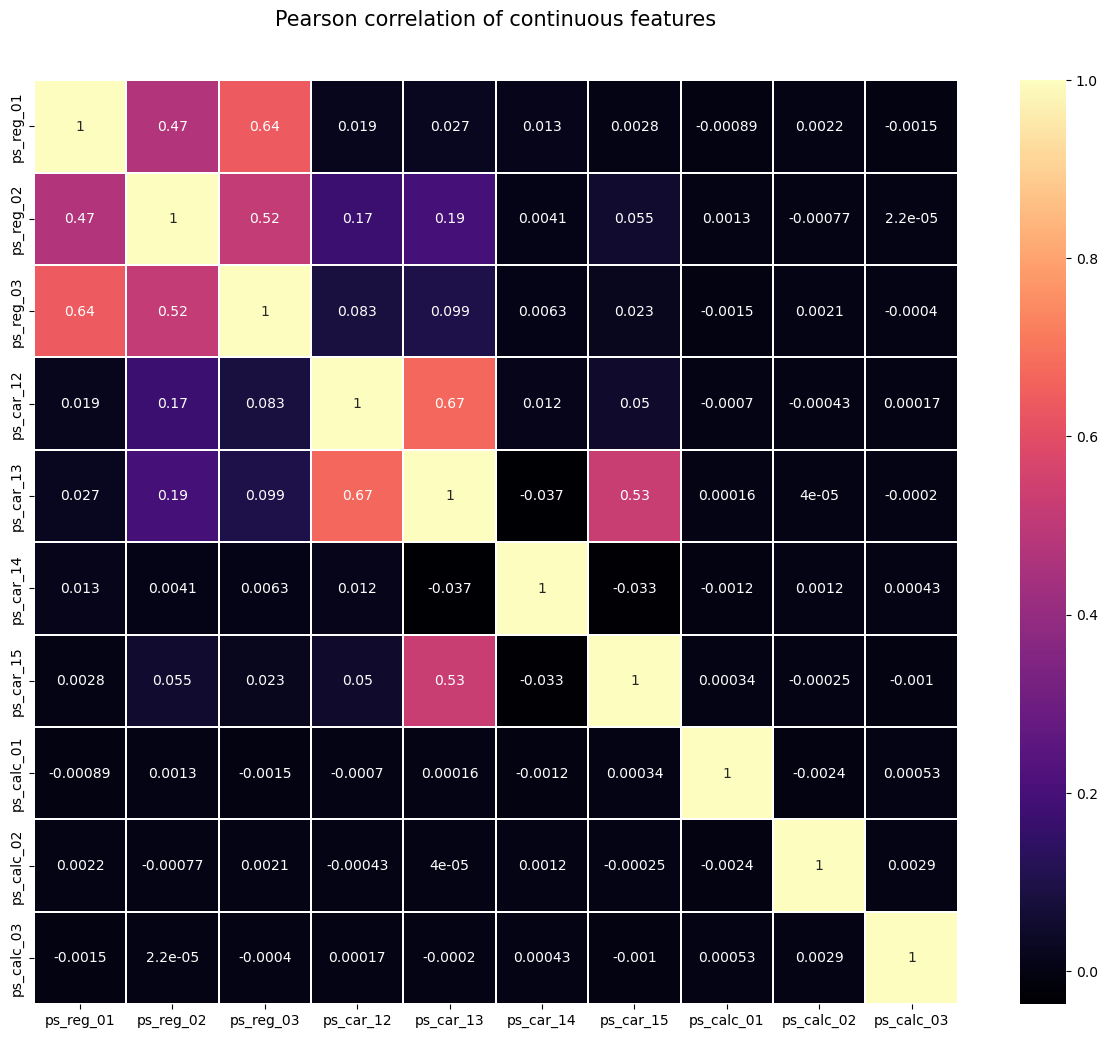

In [42]:
# Correlation of float features

colormap = plt.cm.magma
plt.figure(figsize=(16,12))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(train_float.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True);

### Correlation of integer features
  
For the columns of interger datatype, I shall now switch to using the Plotly library to show how one can also generate a heatmap of correlation values interactively. Much like our earlier Plotly plot, we generate a heatmap object by simply invoking the "go.Heatmap". Here we have to provide values to three different axes, where x and y axes take in the column names while the correlation value is provided by the z-axis. The colorscale attribute takes in keywords that correspond to different color palettes that you will see in the heatmap where in this example, I have used the Greys colorscale (others include Portland and Viridis - try it for yourself).  
  
### DeepL 번역
  
이제 정수 데이터 유형의 열에 대해 Plotly 라이브러리를 사용하여 상관 관계 값의 히트맵을 대화형으로 생성하는 방법을 보여드리겠습니다. 앞의 Plotly 플롯과 마찬가지로, "go.Heatmap"을 호출하여 히트맵 객체를 생성합니다. 여기서는 세 개의 서로 다른 축에 값을 제공해야 하는데, x축과 y축은 열 이름을, 상관관계 값은 z축을 통해 제공됩니다. 색조 속성은 히트맵에서 볼 수 있는 다양한 색상 팔레트에 해당하는 키워드를 사용하며, 이 예에서는 그레이 색조를 사용했습니다(다른 색조로는 포틀랜드와 비리디스가 있습니다. 직접 사용해 보세요).

In [43]:

# train_int = train_int.drop(['id', 'target'], axis=1)
# colormap = plt.cm.bone
# plt.figure(figsize=(21,16))
# plt.title('Pearson correlation of categorical features', y=1.05, size=15)
# sns.heatmap(train_int.corr(), linewidths=0.1, vmax=1., square=True, cmap=colormap, linecolor='white', annot=False)

data = go.Heatmap(z=train_int.corr().values,
                  x=train_int.columns.values,
                  y=train_int.columns.values,
                  colorscale='Viridis',
                  reversescale=False,
                  text=train_int.corr().values,
                  opacity=1.)
layout = go.Layout(title='Pearson Correlation of Integer-type features',
                   xaxis=dict(ticks='', nticks=36), # nticks: 최대 틱 개수
                   yaxis=dict(ticks=''),            # ticks: 눈금 여부.{'': None, 'outside': 'outside', 'inside': 'inside'}
                   width=900, height=700)

fig = go.Figure(data, layout=layout)
py.iplot(fig, filename='labelled-heatmap');

Similarly, we can observe that there are a huge number of columns that are not linearly correlated with each other at all, evident from the fact that we observe quite a lot of 0 value cells in our correlation plot. This is quite a useful observation to us, especially if we are trying to perform dimensionality reduction transformations such as Principal Component Analysis (PCA), this would require a certain degree of correlation . We can note some features of interest are as follows:  
  
__Negatively correlated features__ : ps_ind_06_bin, ps_ind_07_bin, ps_ind_08_bin, ps_ind_09_bin  
  
One interesting aspect to note is that in our earlier analysis on nullity, ps_car_03_cat and ps_car_05_cat were found to contain many missing or null values. Therefore it should come as no surprise that both these features show quite a strong positive linear correlation to each other on this basis, albeit one that may not really reflect the underlying truth for the data.  
  
__DeepL 번역__  
마찬가지로, 상관관계 플롯에서 0 값 셀이 상당히 많이 관찰된다는 사실에서 알 수 있듯이 서로 선형적으로 상관관계가 전혀 없는 열이 엄청나게 많다는 것을 알 수 있습니다. 이는 특히 주성분 분석(PCA)과 같은 차원 축소 변환을 수행하려는 경우 어느 정도의 상관관계가 필요하기 때문에 매우 유용한 관찰입니다. 관심 있는 몇 가지 특징은 다음과 같습니다:  
  
__음의 상관관계가 있는 특징__ : ps_ind_06_bin, ps_ind_07_bin, ps_ind_08_bin, ps_ind_09_bin  
  
주목해야 할 한 가지 흥미로운 측면은 앞서 무효성에 대한 분석에서 ps_car_03_cat과 ps_car_05_cat에 누락되거나 무효화된 값이 많이 포함되어 있는 것으로 나타났다는 점입니다. 따라서 데이터의 근본적인 진실을 반영하지 않을 수도 있지만, 이 두 기능이 서로 상당히 강한 양의 선형 상관관계를 보인다는 것은 놀라운 일이 아닙니다.

### Mutual Information plots
Mutual information is another useful tool as it allows one to inspect the mutual information between the target variable and the corresponding feature it is calculated against. For classification problems, we can conveniently call Sklearn's mutual_info_classif method which measures the dependency between two random variables and ranges from zero (where the random variables are independent of each other) to higher values (indicate some dependency). This therefore will help give us an idea of how much information from the target may be contained within the features.  
  
The sklearn implementation of the mutual_info_classif function tells us that it "relies on nonparametric methods based on entropy estimation from k-nearest neighbors distances", where you can go into more detail on the official sklearn page in the link here.  
  
### DeepL 번역
Mutual information은 대상 변수와 계산 대상인 해당 특징 사이의 상호 정보를 검사할 수 있는 또 다른 유용한 도구입니다. 분류 문제의 경우, 두 무작위 변수 간의 의존성을 측정하고 0(무작위 변수가 서로 독립적인 경우)에서 높은 값(어느 정도 의존성을 나타냄)까지의 범위에서 Sklearn의 mutual_info_classif 메서드를 편리하게 호출할 수 있습니다. 따라서 이 방법을 사용하면 대상의 정보가 특징에 얼마나 많이 포함되어 있는지 파악할 수 있습니다.  
  
mutual_info_classif의 sklearn 구현에 따르면 이 함수는 "k-최근접 이웃 거리의 엔트로피 추정에 기반한 비모수적 방법에 의존"한다고 나와 있으며, [여기 링크의 공식 sklearn 페이지](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#sklearn.feature_selection.mutual_info_classif)에서 더 자세히 살펴볼 수 있습니다.

In [44]:
mf = mutual_info_classif(train_float.values, train.target.values, n_neighbors=3, random_state=17)
print(mf)

[0.02599971 0.00767074 0.00617141 0.01855302 0.00158483 0.00338192
 0.01668813 0.0134428  0.01334669 0.01348572]


### Binary features inspection
Another aspect of the data that we may want to inspect would be the columns that only contain binary values, i.e where values take on only either of the two values 1 or 0. Proceeding, we store all columns that contain these binary values and then generate a vertical plotly barplot of these binary values as follows:  
### DeepL 번역
데이터에서 검사하고 싶은 또 다른 측면은 이진 값만 포함된 열, 즉 값이 1 또는 0의 두 값 중 하나만 취하는 열입니다. 계속해서 이러한 이진 값이 포함된 모든 열을 저장한 다음 다음과 같이 이러한 이진 값의 세로 막대형 막대그래프를 생성합니다:

In [45]:
bin_col = [col for col in train.columns if '_bin' in col]
zero_list = []
one_list = []
for col in bin_col:
    zero_list.append((train[col]==0).sum())
    one_list.append((train[col]==1).sum())

In [46]:
trace1 = go.Bar(x=bin_col, y=zero_list, name='Zero count')
trace2 = go.Bar(x=bin_col, y=one_list, name='One count')

data = [trace1, trace2]
layout = go.Layout(barmode='stack', title='Count of 1 and 0 in binary variables')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

### Categorical and Ordinal feature inspection
Let us first take a look at the features that are termed categorical as per their suffix "_cat".  
  
#### Feature importance via Random Forest
Let us now implement a Random Forest model where we fit the training data with a Random Forest Classifier and look at the ranking of the features after the model has finished training. This is a quick way of using an ensemble model (ensemble of weak decision tree learners applied under Bootstrap aggregated) which does not require much parameter tuning in obtaining useful feature importances and is also pretty robust to target imbalances. We call the Random Forest as follows:  
  
### DeepL 번역
먼저 접미사 "_cat"에 따라 범주형이라고 불리는 특징에 대해 살펴보겠습니다.  
  
#### 랜덤 포레스트를 통한 특징 중요도
이제 랜덤 포레스트 분류기로 훈련 데이터를 맞추고 모델이 훈련을 마친 후 특징의 순위를 살펴보는 랜덤 포레스트 모델을 구현해 보겠습니다. 이는 앙상블 모델(부트스트랩에서 집계된 약한 의사 결정 트리 학습자의 앙상블)을 사용하는 빠른 방법으로, 유용한 특징의 중요도를 얻기 위해 많은 매개변수를 조정할 필요가 없으며 불균형을 타겟팅하는 데도 매우 강력합니다. 우리는 이를 다음과 같이 랜덤 포레스트라고 부릅니다:

In [47]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=150, max_depth=8, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
rf.fit(train.drop(['id', 'target'], axis=1), train.target)
features = train.drop(['id', 'target'], axis=1).columns.values
print("----- Training Done -----")

----- Training Done -----


### Plot.ly Scatter Plot of feature importances
  
Having trained the Random Forest, we can obtain the list of feature importances by invoking the attribute "featureimportances" and plot our next Plotly plot, the Scatter plot.  
  
Here we invoke the command Scatter and as per the previous Plotly plots, we have to define our y and x-axes. However the one thing that we pay attention to in scatter plots is the marker attribute. It is the marker attribute where we define and hence control the size, color and scale of the scatter points embedded.  
  
### DeepL 번역
  
랜덤 포레스트를 훈련했으면 "featureimportances" 속성을 호출하여 특징 중요도 목록을 가져와서 다음 Plotly 플롯인 분산형 플롯을 그릴 수 있습니다.  
  
여기서는 Scatter 명령을 호출하고 이전 Plotly 플롯에 따라 y축과 x축을 정의해야 합니다. 하지만 분산형 차트에서 주의해야 할 한 가지는 마커 속성입니다. 마커 속성을 통해 포함된 분산점의 크기, 색상 및 배율을 정의하고 제어할 수 있습니다.  

In [48]:
## Scatter plot
trace = go.Scatter(y=rf.feature_importances_, 
                   x=features, 
                   mode='markers', 
                   marker=dict(sizemode='diameter', sizeref=1, size=13, 
                               color=rf.feature_importances_, colorscale='Portland', showscale=True),
                               ## size=rf.feature_importances_, ## color=np.random.randn(500), ## set color equal to a variable
                   text=features)
data = [trace]

layout = go.Layout(autosize=True, 
                   title='Random Forest Feature Importance',
                   hovermode='closest', # 그래프에 마우스 커서를 갖다대면 어디의 값이 팝업될지. ( "x" | "y" | "closest" | False | "x unified" | "y unified" )
                   xaxis=dict(ticklen=5, showgrid=False, zeroline=False, showline=False),
                   yaxis=dict(title='Feature Importance', ticklen=5, gridwidth=2, showgrid=False, zeroline=False),
                   showlegend=False)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='scatter2010');

In [49]:
x, y = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, features),
                                     reverse=False)))
trace2 = go.Bar(x=x,
                y=y,
                marker=dict(color=x, colorscale='Viridis', reversescale=True),
                name='Random Forest Feature importance',
                orientation='h')

layout = dict(title='Barplot of Feature importances',
              width=900, height=2000,
              yaxis=dict(showgrid=False, showline=False, showticklabels=True, ## domain=[0,0.85] # domain이 뭔지 못 찾음 
                         ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

### Decision Tree visualisation
  
One other interesting trick or technique oft used would be to visualize the tree branches or decisions made by the model. For simplicity, I fit a decision tree (of max_depth = 3) and hence you only see 3 levels in the decision branch, use the export to graph visualization attribute in sklearn "export_graphviz" and then export and import the tree image for visualization in this notebook.  
  
### DeepL 번역
  
종종 사용되는 또 다른 흥미로운 기술이나 기법 중 하나는 모델이 내린 의사 결정이나 트리 분기를 시각화하는 것입니다. 간단히 설명하기 위해 의사 결정 트리(최대_깊이 = 3)를 맞추었으므로 의사 결정 가지에 3단계만 표시되도록 하고, sklearn "export_graphviz"에서 그래프 시각화 내보내기 속성을 사용한 다음 이 노트북에서 시각화를 위해 트리 이미지를 내보내고 가져옵니다.